<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/nlp_for_gdp_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
US GDP data is released every three months. Is it possible to forecast the next (in 0-3 months) GDP data release by using the data available from any source before then? Also interesting: is it possible to forecast the 2nd GDP release from today (3-6 months from now), or even the 3rd GDP release from today (6-9 months from now)?
## New Section
Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using these publically available sources, this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a handful of 'classically important' economic measures that economist's have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Numerical Data
Most of the numerical data are aggregated from direct measures of economic activity (such as dollar of goods sold, or number of building permits issued). Other numerical data are aggregations of surveys completed by participents in the economy (such as the PMI index, or the GDP Nowcast).

#### Textual Data
The textual data for this notebook is from the Institue for Supply Management's (ISM) Report on Business which is also the source of the some of the numerical data: PMI Index, and NMI Index. This report has been published on the first day of the month since the 1940's under a few different names--the most-used being the "PMI", or "Purchasing Managers Index". 

Confusingly, other research firms release data with the name "PMI", but this notebook will use the ISM's PMI report as it has the longest history.

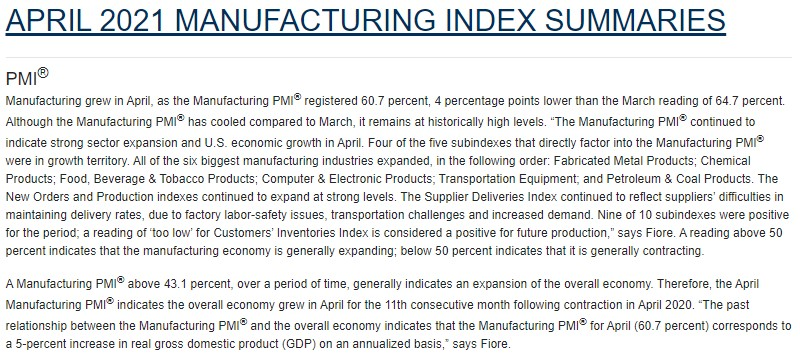


Along the numerical data in each report, the ISM summarizes the survey reponses in a few paragraphs at the beginning of the report, and for each subsection. Additionally, one sections include a selection of quotes from survey respondants. These quote's are often 'soundbite-like' and add sentiment to the report.

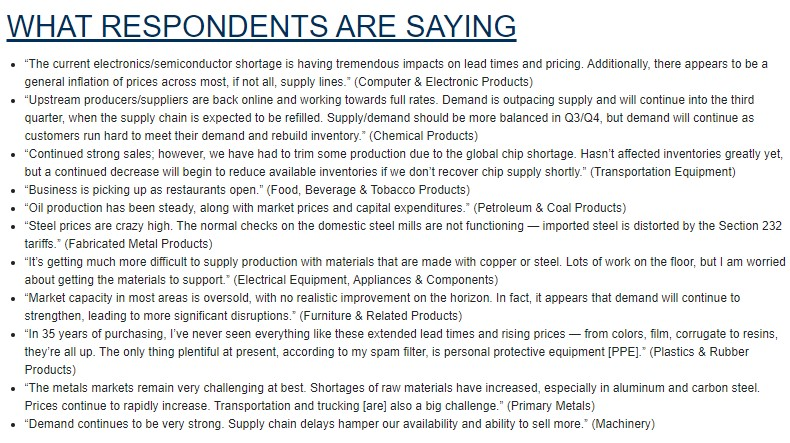



These textual summaries and quotes will be the input to the NLP model. 

## Todo List:
1. Scrape the text data from the PMI and NMI releases.
2. Approriately process the text data with nltk, GenSim, or similar.
3. Perform baseline modelling to choose a set of models to tune further.
4. Write up 
  * Exploration - talk about the important features
  * 3 important one, 3 non important ones
  * bivariate chart showing relation between them
  * show distributions
  * EDA: group categories with high-ratio and low-ratio, instead of having hundreds of categories.
  * Wrangling- describe manipulation and data changes
  * Methods
  * Make a plot n_sample for training, as a function of performance on the validation (always use the same test set). Look for a convergence of the performance after reaching sufficne samples. Use the best hyperparameters, not a grid search. (Try decision tree first, because it's fast.
  * discussion on each model, with summary of advs and disadvs of each model, assumptions
  * Most important  is to describe shortcomings of the data and analysis-room for improvement. Weaknesses/ limitations in the model. Show readers where the model and analysis can be improved.
  * Explain the choices made in the analysis
  * statistical tests of significance
  * Show chart with final perf on test set


## Completed list:
1. Gather and preprocess numerical data from Fed and Quandl.
2. Perform baseline modelling on the numerical data only.
* id important features have strong variation  with target var

# Imports

In [1]:
# Set api key variables
% cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

# import config
# API_KEY = config.API_KEY

from pathlib import Path
import os
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


## Modules

In [2]:
# install chromium, its driver, and selenium
! apt update
! apt install chromium-chromedriver

# Install and upgrade modules
! pip install -U beautifulsoup4 selenium scrapy
! pip install -U numpy matplotlib seaborn
! pip install -U tsfresh tqdm requests_cache pandas-datareader 
! pip install -U statsmodels scipy hcrystalball pmdarima tbats
! pip install -U pandas 

! pip install -U spacy
! python -m spacy download en_core_web_sm
! python -m spacy download en_core_web_trf
! python -m spacy download en_vecs
! python -m spacy validate

! pip install -U stanza gensim
# for displaying trees on virtual display
# Install X Virtual Frame Buffer and ghostscript
!apt install -y xvfb 
!apt install ghostscript python3-tk  

! pip install afinn -U

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graph

In [3]:
import re
import pickle
import unicodedata
import requests
import os

import requests_cache
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import spacy

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('conll2000')

# Load contraction map
from contractions import CONTRACTION_MAP

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm

import stanza
stanza.download('en') 

from pprint import pprint

pd.options.display.max_colwidth = 200
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


2021-06-13 19:59:01 INFO: Downloading default packages for language: en (English)...
2021-06-13 19:59:03 INFO: File exists: /root/stanza_resources/en/default.zip.
2021-06-13 19:59:08 INFO: Finished downloading models and saved to /root/stanza_resources.


# Data Retrieval with Web Scraping

The archived text of the ISM releases are hard to get, while the numerical data are easy to find. For this data, we'll scrap the news releases from PR News Wire as the ISM releases after 2012 are still available there.

## Web scraping static content with Beautiful Soup and Requests

In [4]:
url_root = 'https://www.prnewswire.com/news/institute-for-supply-management'
urls = [ f'{url_root}/?page={p}&pagesize=100' \
        for p in (1, 2, 3, 4)]
session = requests_cache.CachedSession('news_cache')
headers = {'User-Agents': 'Mozilla/5.0',
           'referer': url_root}

# Identify links of interest
links = []
links_suffixes = []
for url in urls:
  # Use requests to retrieve data from a given URL
  news_response = session.get(url, headers=headers)
  # Parse the whole HTML page using BeautifulSoup
  news_soup = BeautifulSoup(news_response.text, 'html.parser')
  # Get a list of all the links
  for link in news_soup.find_all('a'):
    # print(link.get('href'))
    # print(type(link.get('href')))
    href = str(link.get('href'))
    if 'news-release' in href:
      # Filter the links to include the phrase 'PMI-at'
      if 'pmi-at' in href \
      and 'hospital' not in href \
      and 'services' not in href: 
        suffix = link.get('href').replace('/news-releases', '')
        links.append(f'{url_root}{suffix}')
        links_suffixes.append(suffix)
      # elif 'nmi-at' in str(link.get('href')):
      # links.append(link.get('href'))
direct_links = ['https://www.prnewswire.com/news-releases'+ suffix for suffix in links_suffixes ]
len(links), len(links_suffixes), len(direct_links)

(99, 99, 99)

In [5]:
links[:5]

['https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-7-april-2021-manufacturing-ism-report-on-business-301281490.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-64-7-march-2021-manufacturing-ism-report-on-business-301260206.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-8-february-2021-manufacturing-ism-report-on-business-301236952.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-58-7-january-2021-manufacturing-ism-report-on-business-301218544.html']

In [6]:
# for link in links[0:2]:
print(direct_links[0])
res = session.get(direct_links[0])
soup = BeautifulSoup(res.text, 'html.parser')
# soup

https://www.prnewswire.com/news-releases/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html


Lots of info is missing from the text here, while the missing text does show correctly in a web browser. It looks like the interesting content of this page is rendered in the javascript, so we'll need a tool suitable for scraping dyanmic web pages.

## Web scraping dynamic content with Selenium

In [7]:
# from selenium.webdriver import ChromeOptions, Chrome
# # from selenium.webdriver.support import expected_conditions as EC
# # from selenium.webdriver.common.by import By
# # from selenium.webdriver.support.ui import WebDriverWait

# def start_new_driver():
#   # set options to be headless, ..
#   options = ChromeOptions()
#   options.add_argument('--headless')
#   options.add_argument('--no-sandbox')
#   options.add_argument('--disable-dev-shm-usage')
#   prefs = {
#       # Skip loading images
#       'profile.managed_default_content_settings.images':2,
#       # Use disk cache
#       "profile.managed_default_content_settings.images": 2,
#       'disk-cache-size': 4096
#       }
#   options.add_experimental_option("prefs", prefs)
#   # open it, go to a website, and get results
#   driver = Chrome(options=options)
#   return driver

# # Get page sources
# page_sources = []
# page_urls = []
# for direct_link in tqdm(direct_links, desc='direct_links'):
#     driver = start_new_driver()
#     driver.get(direct_link)
#     raw_page_source = driver.page_source
#     # Unicode-normalize the source
#     normalized_page_source = unicodedata.normalize('NFKD', raw_page_source)
#     page_sources.append(normalized_page_source)
#     page_urls.append(driver.current_url)
#     driver.close()

# # Save page sources
# page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
# with open(page_sources_path, 'wb') as f:
#   pickle.dump(page_sources, f)

# page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
# with open(page_urls_path, 'wb') as f:
#   pickle.dump(page_urls, f)

# len(page_sources), len(page_urls)

In [8]:
# Load page sources with this cell, or uncomment cell above to scrape fresh data (it's slow)
page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
with open(page_sources_path, 'rb') as f:
  page_sources = pickle.load(f)

page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
with open(page_sources_path, 'rb') as f:
  page_urls =  pickle.load(f)

len(page_sources), len(page_urls)

(99, 99)

In [9]:
normalized_page_sources = []
for raw_page_source in page_sources:
  normalized_page_sources.append(unicodedata.normalize('NFKD', raw_page_source))
page_sources = normalized_page_sources

# Assert that all urls and page_sources are unique
df = pd.DataFrame({'url': page_urls, 'page_source': page_sources})
assert df['url'].is_unique
assert df['page_source'].is_unique

len(page_sources)

99

# Processing & Understanding Text


## Parse the Release body

In [10]:
#Parse release_bodies from page source
releases = []
paragraphs_all_releases_soup = []
paragraphs_all_releases_text = []
for i, release_page_source in enumerate(page_sources):
  # print(release_page_source)
  release = {}
  soup = BeautifulSoup(release_page_source, 'html.parser')
  release['release_body'] = soup.find('section', 'release-body')
  paragraphs_this_release = release['release_body'].find_all('p')
  release['paragraphs'] =  paragraphs_this_release
  for paragraph in paragraphs_this_release:
    paragraphs_all_releases_soup.append(paragraph)
    paragraphs_all_releases_text.append(paragraph.text)
  # Select the first date in the release body
  date = release['release_body'].select('span.xn-chron')[1].text
  # print(date)
  # print(release['paragraphs'][0:5])
  release['date'] = date
  releases.append(release)
len(releases), len(paragraphs_all_releases_soup), len(paragraphs_all_releases_text)

(99, 62940, 62940)

#### Tests: Check the properties of the release bodies

In [11]:
# check to make sure the release bodies are unique
df = pd.DataFrame.from_dict(releases)
assert df['release_body'].is_unique
assert df['paragraphs'].apply(repr).is_unique

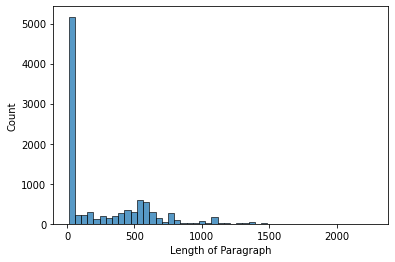

In [12]:
# Compare number of paragraphs in different releases to see if the number is constant,
# which would indicate a stable paragraph structure in the text
lengths = []
for paragraph_text in paragraphs_all_releases_text:
  # ignore paragraphs shorter than 10:
  if len(paragraph_text)>10:
    lengths.append(len(paragraph_text)) 
lengths_hist = sns.histplot(lengths)
lengths_hist.set(xlabel='Length of Paragraph');

No conclusion can be made with the paragraph structure alone. There are lots of zero-length paragraphs.

In [13]:
# check for paragraphs that are repeated accross multiple releases.
all_paragraphs_series = pd.Series(paragraphs_all_releases_text, name='paragraphs_all_releases_text')
all_paragraphs_series.is_unique

False

Some paragraphs  not unique. What are the most common paragraphs?


We see that there are non-unique paragraphs in the corpus. Which are they?

In [14]:
all_paragraphs_series.value_counts()

Index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1092
Net                                                                                                                                                                                                                                                                                                                                                                                                   

## Identify Relevant Paragraphs from Release Body


The paragraphs groups of interest are:
* Summary
* What Respondants are Saying 
* Commodities Up in Price 
* Commodities Down in Price 
* Commodities in Short Supply

Other paragraphs will not be included in this notebook.

All the PMI reports include the same paragraph groups, except for minor and infrequent changes to format, such as when the ISM changed the name of the report from PMI to Manufacturing PMI.

### Summary

In [15]:
# Parse from the top and group the text as the first group, summary. 
# Stop parsing upon encountering the string: 'WHAT RESPONDENTS ARE SAYING'

import dateutil.parser

def parse_summary(paragraphs: bs4.element.ResultSet):
  summary_paragraphs_by_release = []
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # fix unicode change to a common string, PMITM to PMI
    text = re.sub('( PMITM )|( PMI® )', ' PMI ', text)
    if not text:
      # Some paragraphs are exclusively whitespace, so exclude these
      continue
    elif re.match('.*DO NOT CONFUSE THIS NATIONAL REPORT.*', text):
      # Exclude this non-informative paragraph that only clarifies that this 
      # report is not the same  as another report
      continue
    elif re.match('^.+\/PRNewswire\/ -- ', text):
      # Remove this portion of paragraph, containing only the location, date and byline of the news outlet
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^.+\/PRNewswire\/ -- ', '', text))
    elif re.match('^The report was issued today by.*Survey Committee.\s', text):
      # Remove this portion of paragraph, containing only person presenting the report
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^The report was issued today by.*Survey Committee.\s', '', text))
    elif 'WHAT RESPONDENTS ARE SAYING' in text:
      #End of summary section; beginning of next section
      break
    else:
      summary_paragraphs_by_release.append(text)
  return summary_paragraphs_by_release

summary_paragraphs_by_release = [parse_summary(release['paragraphs']) for release in releases]
len(summary_paragraphs_by_release)

99

In [16]:
summary_paragraphs_by_release[0]

["New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Exports and Imports Growing",
 "Economic activity in the manufacturing sector grew in May, with the overall economy notching a 12th consecutive month of growth, say the nation's supply executives in the latest Manufacturing ISM® Report On Business®.",
 'The report was issued today by Timothy R. Fiore, CPSM, C.P.M., Chair of the Institute for Supply Management® (ISM®) Manufacturing Business Survey Committee:',
 '"The May Manufacturing PMI registered 61.2 percent, an increase of 0.5 percentage point from the April reading of 60.7 percent. This figure indicates expansion in the overall economy for the 12th month in a row after contraction in April 2020. The New Orders Index registered 67 percent, increasing 2.7 percentage points from the April reading of 64.3 percent. The Production Index registere

In [17]:
summary_paragraphs_flat_by_release = []
for summary_paragraphs in summary_paragraphs_by_release:
  summary_paragraphs_flat_by_release.append(' '.join(summary_paragraphs))

<AxesSubplot:>

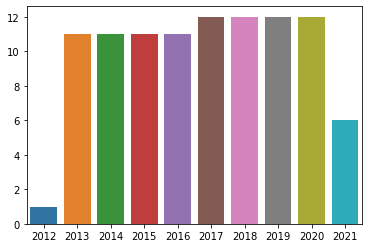

In [18]:
def parse_date(paragraphs: bs4.element.ResultSet):
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # Parse the date from this paragraph
    match = re.match('^.+\/PRNewswire\/ -- ', text)
    if match:
      # print(paragraph)
      date_string = paragraph.select('span.xn-chron')[0].text
      return pd.to_datetime(date_string)

release_dates = [parse_date(release['paragraphs']) for release in releases]
dates_count = pd.Series(release_dates).dt.year.value_counts()
sns.barplot(x=dates_count.index,
            y=dates_count)

We can see that there are some missing months. These releases are missing from the news relese source, unfortunately.

Missing years and month: 
* 2013: 3,
* 2014: 5, 
* 2015: 8, 
* 2016: 11

In [19]:
summary_paragraphs[0]

"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's supply executives in the latest Manufacturing ISM Report On Business®."

### What Respondants are Saying

This section contain quotes from the anonymous supply managers responding to the survey. These quotes may be cherry-picked by the decision makers who compile the report, but this section of the report is probably the most useful as an input into and NLP sentiment analysis model.

In [20]:
# abbreviation: wras = what_respondants_are_saying
def parse_wras(releases: list):
  wras_soups = []
  wras_texts = []
  wras_soups_flat = []
  wras_texts_flat = []
  for release in tqdm(releases):
    wras_soup = release['release_body'].find_all('li')
    wras_soups.append(wras_soup)

    wras_text = [unicodedata.normalize('NFKD', tag.text.strip()) for tag in wras_soup]
    wras_texts.append(wras_text)
    
    for tag in wras_soup:
      wras_soups_flat.append(tag)
    for text in wras_text:
      wras_texts_flat.append(text)
  assert len(wras_soups)==len(wras_texts)
  assert len(wras_soups_flat)==len(wras_texts_flat)
  return (wras_soups,  # List of lists of soups
          wras_texts,    # List of lists of texts
          wras_soups_flat, # lists of soups
          wras_texts_flat) # lists of texts

(wras_soups,
  wras_texts,  
  wras_soups_flat,
  wras_texts_flat) = parse_wras(releases)  

len(wras_soups), len(wras_texts), len(wras_soups_flat), len(wras_texts_flat)

  0%|          | 0/99 [00:00<?, ?it/s]

(99, 99, 998, 998)

In [21]:
wras_texts[:1]

[['"Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up." [Computer & Electronic Products]',
  '"Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales." [Chemical Products]',
  '"Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented." [Transportation Equipment]',
  '"Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels." [Food, Beverage & Tobacco Products]',
  '"[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for meeting delivery da

#### Parse WRAS quote and industry

In [22]:
wras_tuples_by_release = []
wras_tuples_flat = []
for quote_and_ind_str_list in wras_texts:
  inner_wras_tuples = []
  for quote_and_ind_str in quote_and_ind_str_list:
    match_0 = re.match('\"?(.+)\"?\s\((.*)\)', quote_and_ind_str)
    match_1 = re.match('"(.*")\s+[/(/[]([A-Z].*)[\]\)]', quote_and_ind_str)
    if match_0:
      # print(match_0)
      # print(match_0.group(1)[:20], match_0.group(2))
      inner_wras_tuples.append((match_0.group(1), match_0.group(2)))
      wras_tuples_flat.append((match_0.group(1), match_0.group(2)))
    elif match_1:
      # print(match_1)
      # print(match_1.group(1)[:20], match_1.group(2))
      inner_wras_tuples.append((match_1.group(1), match_1.group(2)))
      wras_tuples_flat.append((match_1.group(1), match_1.group(2)))
    else:
      # Too few to matter (<4), ignore precessing these outliers; just append as-is
      # print(quote_and_ind_str)
      continue
  wras_tuples_by_release.append(inner_wras_tuples)

len(wras_tuples_by_release), len(wras_tuples_flat)

(99, 997)

In [23]:
wras_tuples_by_release[:1]

[[('Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up."',
   'Computer & Electronic Products'),
  ('Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales."',
   'Chemical Products'),
  ('Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented."',
   'Transportation Equipment'),
  ('Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels."',
   'Food, Beverage & Tobacco Products'),
  ('[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for

In [24]:
wras_texts_by_release = []
wras_texts_flat_by_release = []
wras_industries_by_release = []
wras_industries_flat_by_release = []
for wras_tuples in wras_tuples_by_release:
  wras_text, wras_industries = zip(*wras_tuples)
  wras_text_flat = ' '.join(wras_text)
  wras_industries_flat = ' '.join(wras_industries)

  wras_texts_by_release.append(wras_text)
  wras_texts_flat_by_release.append(wras_text_flat)
  wras_industries_by_release.append(wras_industries)
  wras_industries_flat_by_release.append(wras_industries_flat)

### Commodities Up, Down, and in short supply

This section is not likely to be useful for a sentiment analysis. But, this does appear to be a useful source of categorical data that could later be transformed into usefuls numerical series as an input to any model.

One possible modelling application would be to test a hypothesis that the data in this section is a leading indicator of commodity prices.

#### Parse commodites up/down in price and short supply from Paragraphs

In [25]:
comm_up_lists = []
comm_down_lists = []
comm_short_lists = []
comm_up_lists_flat = []
comm_down_lists_flat = []
comm_short_lists_flat = []
for i, release in enumerate(releases):
  # Up
  comm_up_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').get_text().replace('Commodities Up in Price', '').strip())
  if not comm_up_inter_str:
    # print('if up_4')
    comm_up_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  
  if re.match('The only commodity listed up in price.+is\s',comm_up_inter_str):
    # print('up_match_1')
    comm_up_str = re.sub('The only commodity listed up in price.+is\s', '', comm_up_inter_str)
  else:
    comm_up_str = comm_up_inter_str
  
  if re.search('Commodities', comm_up_str):
    comm_up_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('span').get_text().replace('Commodities Up in Price', '').strip()
  
  # Source forgot a semi-colon one time
  if comm_up_inter_str == 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2) and Steel Products* (10).':
    comm_up_str = 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2); and Steel Products* (10).'
  
  assert comm_up_str
  assert not re.search('Commodities', comm_up_str)
  # print(i, '\t', comm_up_str)

  # Down
  comm_down_heading_text = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice'))
  if comm_down_heading_text:
    if 'Up' in comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip():
      # print('if Up')
      comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent().find_parent().get_text()
    else:
      comm_down_inter_str = comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if down_4')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  else:
    # print('if 2')
    comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if 3')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.next_sibling.get_text()
  assert comm_down_str
  assert not re.search('Commodities', comm_down_str)
  # print(i, '\t', comm_down_str) 

  # Short
  comm_short_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('p').get_text().replace('Commodities in Short Supply', '').strip())
  if re.match('[Nn]o\scommodities\s.*\sshort\ssupply',comm_short_inter_str):
    # print(i, 'short_match_1')
    comm_short_str = re.sub('.*[Nn]o\scommodities\s.*\sshort\ssupply.*', 'None.', comm_short_inter_str)
  elif re.match('.*\sis\sthe\sonly\scommodity.*',comm_short_inter_str):
    # print(i, 'short_match_2')
    comm_short_str = re.sub('\sis\sthe\sonly\scommodity.*', '', comm_short_inter_str)
  elif re.match('.*no commodities listed in short supply.*', comm_short_inter_str):
    # print(i, 'short_match_3')
    comm_short_str = re.sub('^.*no commodities listed in short supply.*', 'None.', comm_short_inter_str)
  elif re.match('The only commodity.*short supply.*is\s', comm_short_inter_str):
    # print(i, 'short_match_4')
    comm_short_str = re.sub('The only commodity.*short supply.*is\s', '', comm_short_inter_str)
  elif re.match('Commodities\s.*in', comm_short_inter_str):
    # print(i, 'short_match_5')
    comm_short_str = release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('span').get_text().replace('Commodities in Short Supply ', '').strip()
  else:
    comm_short_str = comm_short_inter_str
  assert comm_short_str
  assert not re.search('Commodities', comm_short_str)

  # if re.match('Commodities\s.*in', comm_short_str):
  #   print(i, comm_short_str)
  #   raise
  # print(i, '\t', comm_short_str)
  # print(comm_short_str)
  
  # Remove any final '.'
  comm_up_list = re.sub('\.$', '', comm_up_str)
  comm_down_list = re.sub('\.$', '', comm_down_str)
  comm_short_list = re.sub('\.$', '', comm_short_str)

  # Split string into list at ';'
  comm_up_list = comm_up_str.split('; ')
  comm_down_list = comm_down_str.split('; ')
  comm_short_list = comm_short_str.split('; ')

  # # strip white space
  comm_up_list = [ele.strip() for ele in comm_up_list]
  comm_down_list = [ele.strip() for ele in comm_down_list]
  comm_short_list = [ele.strip() for ele in comm_short_list]

  # Append to list
  comm_up_lists.append(comm_up_list)
  comm_down_lists.append(comm_down_list)
  comm_short_lists.append(comm_short_list)

  for ele in comm_up_list:
    comm_up_lists_flat.append(ele)
  for ele in comm_down_list:
    comm_down_lists_flat.append(ele)
  for ele in comm_short_list:
    comm_short_lists_flat.append(ele)


In [26]:
# Check lengths
len(comm_up_lists), len(comm_down_lists), len(comm_short_lists)

(99, 99, 99)

In [27]:
# Check lengths
len(comm_up_lists_flat), len(comm_down_lists_flat), len(comm_short_lists_flat)

(1342, 575, 422)

#### Parse commodities and months Up/Down/Short-supply from "Commodites Up/Down in Price and Short Supply"

In [28]:
def parse_commodities_up_down_short_string(commodity_str, debug=False):
  # Remove unicode and Replace *
  commodity_str = unicodedata.normalize('NFKD', commodity_str).replace('*', '')

  # Check for 'None'
  match_none_no_digits = re.match('^None.$', commodity_str)
  match_none_digits = re.match('^None\s\((\d+)\)\.$', commodity_str)

  # Check for 'no commoditites are...'
  match_no_commod_no_digits = re.match('No commodities are', commodity_str)
  match_no_commod_digits = re.match('No commodities are.* \((\d+)\)', commodity_str)
  # Check for 'only commodity...'
  match_only_commodity_digits = re.match('(.+) \((\d+)\) is the only commodity.*', commodity_str)
  match_only_commodity_no_digits = re.match('([A-Z0-9#].*) is the only commodity.+\.', commodity_str)
  
  if match_none_no_digits or match_no_commod_no_digits:
    commod_str = 'None'
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_none_no_digits or match_no_commod_no_digits')
      print(commodity_str)
      print(tup)
  elif match_none_digits:
    commod_str = 'None'
    digits = int(match_none_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_none_digits')
      print(commodity_str)
      print(tup)
  elif match_no_commod_digits:
    commod_str = 'None'
    digits = int(match_no_commod_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_no_commod')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_no_digits:
    commod_str = match_only_commodity_no_digits.group(1)
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_digits:
    commod_str = match_only_commodity_digits.group(1)
    digits = match_only_commodity_digits.group(2)
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  else:
    # Check for 'and...commod_str..(digits)
    match_2 = re.match('^and\s([A-Z#\d].*)\s\((\d+)\)', commodity_str) # and..., with no period at end
    match_3 = re.match('^and\s(.*)', commodity_str)
    if match_2:
      commod_str = match_2.group(1)
      digits = int(match_2.group(2))
      tup = (commod_str, digits)
      if debug:
        print('match_2')
        print(commodity_str)
        print(i, match_2.groups())
        print(tup)
    elif match_3:
      commod_str = re.sub('\.$', '', match_3.group(1))
      digits = 1
      tup = (commod_str, digits)
      if debug:
        print('match_3')
        print(commodity_str)
        print(i, match_3.groups())
        print(tup)
    else:
      # Check for 'comod_str...(digits)
      match_4 = re.match('^([A-Z0-9#].*)\s\((\d+)\)$', commodity_str)
      match_5 = re.match('^([A-Z0-9#].*)', commodity_str)
      if match_4:
        commod_str = match_4.group(1)
        digits = int(match_4.group(2))
        tup = (commod_str, digits)
        if debug:
          print('match_4')
          print(commodity_str)
          print(i, match_4.groups())
          print(tup)
      elif  match_5:
        commod_str = match_5.group(1)
        digits = 1
        tup = (commod_str, digits)
        if debug:
          print('match_5')
          print(commodity_str)
          print(i, match_5.groups())
          print(tup)
      else:
        # If it doesn't match any ohter regular expression
        print(i, commodity_str)
        raise Error
  return tup

In [29]:
commodities_up_by_release = []
for comm_up_list in comm_up_lists:
  this_release = []
  for commod_up in comm_up_list:
    this_release.append(parse_commodities_up_down_short_string(commod_up))
  commodities_up_by_release.append(this_release)

commodities_down_by_release = []
for comm_down_list in comm_down_lists:
  this_release = []
  for commod_down in comm_down_list:
    this_release.append(parse_commodities_up_down_short_string(commod_down))
  commodities_down_by_release.append(this_release)

commodities_short_by_release = []
for comm_short_list in comm_short_lists:
  this_release = []
  for commod_short in comm_short_list:
    this_release.append(parse_commodities_up_down_short_string(commod_short))
  commodities_short_by_release.append(this_release)

In [30]:
len(commodities_up_by_release), len(commodities_down_by_release), len(commodities_short_by_release)

(99, 99, 99)

In [31]:
commodities_names_up_by_release = []
commodities_names_up_flat_by_release = []
for tup in commodities_up_by_release:
  commodities_names_up, _ = zip(*tup)
  commodities_names_up_by_release.append(commodities_names_up)
  commodities_names_up_flat_by_release.append(', '.join(commodities_names_up))

commodities_names_down_by_release = []
commodities_names_down_flat_by_release = []
for tup in commodities_down_by_release:
  commodities_names_down, _ = zip(*tup)
  commodities_names_down_by_release.append(commodities_names_down)
  commodities_names_down_flat_by_release.append(', '.join(commodities_names_down))

commodities_names_short_by_release = []
commodities_names_short_flat_by_release = []
for tup in commodities_short_by_release:
  commodities_names_short, _ = zip(*tup)
  commodities_names_short_by_release.append(commodities_names_up)
  commodities_names_short_flat_by_release.append(', '.join(commodities_names_short))

##### Check Outputs

In [32]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_names_up_by_release)):
#   print(f'{i},\t{comm_up_lists[i][0]},\t{commodities_up_by_release[i][0]}')

In [33]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_down_by_release)):
#   print(f'{i},\t{comm_down_lists[i][0]},\t{commodities_down_by_release[i][0]}')

In [34]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_short_by_release)):
#   print(f'{i},\t{comm_short_lists[i][0]},\t{commodities_short_by_release[i][0]}')

## Variables for further use:

`summary_paragraphs`,
`wras_tuples`,
`commodities_up`,
`commodities_down`,
`commodities_short`,

### Check the variables

In [35]:
# summary_paragraphs[0]

In [36]:
# wras_texts_flat_by_release[2]

In [37]:
# commodities_up_by_release[0]

In [38]:
# commodities_down_by_release[0]

In [39]:
# commodities_short_by_release[0]

## Make dataframes from parsed variables

In [40]:
dates_ser = pd.Series(release_dates, name='date')

summary_ser = pd.Series( summary_paragraphs_flat_by_release, 
                        name='summary')

wras_text_ser = pd.Series(wras_texts_flat_by_release, name='wras')

commodities_up_ser = pd.Series(commodities_names_up_flat_by_release, name='commodities_up_in_price')
commodities_up_count_ser = pd.Series([len(commodities_up) for commodities_up in commodities_up_by_release], 
                                     name='commodities_up_count')

commodities_down_ser = pd.Series(commodities_names_down_flat_by_release, name='commodities_down_in_price')
commodities_down_count_ser = pd.Series([len(commodities_down) for commodities_down in commodities_down_by_release], 
                                       name='commodities_down_count')

commodities_short_ser = pd.Series(commodities_names_short_flat_by_release, name='commodities_in_short_supply')
commodities_short_count_ser = pd.Series([len(commodities_short) for commodities_short in commodities_short_by_release], 
                                        name='commodities_short_count')

df = pd.DataFrame(data=[dates_ser,
                        summary_ser,
                        wras_text_ser,
                        commodities_up_ser,
                        commodities_up_count_ser,
                        commodities_down_ser,
                        commodities_down_count_ser,
                        commodities_short_ser,
                        commodities_short_count_ser]).T
df['date'] = pd.to_datetime(df['date'])
df['summary'] = df['summary'].astype('string')
df['wras'] = df['wras'].astype('string')
df['commodities_up_count'] = df['commodities_up_count'].astype(int)
df['commodities_down_count'] = df['commodities_down_count'].astype(int)
df['commodities_short_count'] = df['commodities_short_count'].astype(int)
df = df.set_index('date').sort_index()
df

,summary,wras,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_in_short_supply,commodities_short_count
date,,,,,,,,
2012-12-03,"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's suppl...","Conditions still appear to be positive for continued growth in sales."" Business is steady, but not much more than that. We are in a lull."" The principle business conditions that will affect the co...","Aluminum Products, Caustic Soda, Corrugated Boxes/Packaging, Polypropylene, Propylene, Steel, Steel – Hot Rolled",7,"Fuel, Oil, Steel",3,None,1
2013-01-02,"Economic activity in the manufacturing sector expanded in December, following one month of contraction, and the overall economy grew for the 43rd consecutive month, say the nation's supply executi...","Many Chinese sources are coming to us with cost reductions to maintain their current business volumes."" Saw some stronger than expected demand in October and November, but December demand is weak ...","Aluminum Products, Benzene, Caustic Soda, Corn Based Products, Corrugated Boxes/Packaging, Plastics, Plastic Components/Products, Polypropylene, Stainless Steel, Steel, Steel – Hot Rolled",11,"Eggs, Steel, Sugar, Titanium Dioxide",4,None,1
2013-02-01,This report reflects the U.S. Department of Commerce's recently completed annual adjustment to the seasonal factors used to calculate the indexes. Economic activity in the manufacturing sector ex...,"Fiscal cliff, uncertainty in general and EU economic weakness are factors causing our customers to be very tentative with commitments for product purchases in 2013."" Midwest drought impact will be...","Aluminum Products, Benzene, Caustic Soda, Copper, Copper Based Products, Corrugated Boxes/Packaging, HDPE, Lumber, Oil, PET Bottles, Polypropylene, Polystyrene, Stainless Steel Sheet, Steel — Cold...",15,"Steel, Sugar, Titanium Dioxide, Wheat",4,None,1
2013-04-01,"Economic activity in the manufacturing sector expanded in March for the fourth consecutive month, and the overall economy grew for the 46th consecutive month, say the nation's supply executives in...","Beginning to feel the seasonal upswing in business — energy and resin remain a concern."" Medical reimbursements from insurance companies, particularly Medicare, are slowing."" While the second half...","Corrugated Boxes, HDPE, Lumber, Pallets, Plastic Resins, Polypropylene",6,"Sugar, Wheat",2,None,1
2013-05-01,"Economic activity in the manufacturing sector expanded in April for the fifth consecutive month, and the overall economy grew for the 47th consecutive month, say the nation's supply executives in ...","Business can be described as flat at best."" Production is still strong; several new projects to support alternative energy."" Slight uptick in business, but overall continuing slowdown in defense d...","Caustic Soda, Corrugated Boxes, HDPE, Lumber, Natural Gas, Plastic Resins, Polypropylene",7,"Aluminum, Steel, Steel — Cold Rolled",3,None,1
...,...,...,...,...,...,...,...,...
2021-02-01,"New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Expo...","Supplier factory capacity is well utilized. Increased demand, labor constraints and upstream supply delays are pushing lead times. This is more prevalent with international than U.S.-based supplie...","Acrylonitrile Butadiene Styrene (ABS) Plastic, Aluminum, Ammonia, Brass Products, Calcium Carbonate, Copper, Corn, Corrugate, Corrugated Boxes, Crude Oil, Diesel, Electrical Components, Electronic...",47,Caustic Soda.,1,"Copper, Corrugate, Corrugated Boxes, Electrical Components, Electronic Components, Freight — Road, Personal Protective Equipment (PPE) — Gloves, Semiconductors, Steel, Steel — Cold Rolled, Steel

In [41]:
# Check for missing data
df.isna().sum()

summary                        0
wras                           0
commodities_up_in_price        0
commodities_up_count           0
commodities_down_in_price      0
commodities_down_count         0
commodities_in_short_supply    0
commodities_short_count        0
dtype: int64

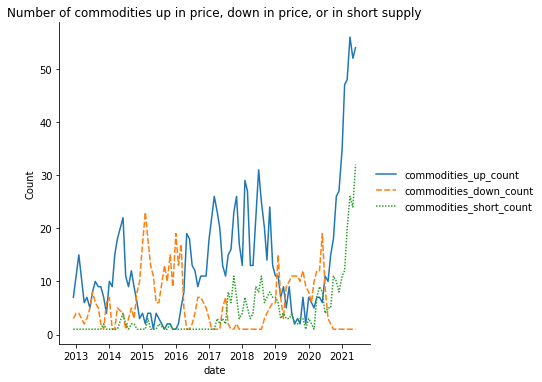

In [42]:
g= sns.relplot(data=df,
                kind='line')
g.set(ylabel='Count',
      title='Number of commodities up in price, down in price, or in short supply');

We can see from the plot that, recently, more commodities are up in price than at any other time since 2012, and more commodities are in short supply than at any other time since 2012.

## Define text processing functions

In [43]:
nlp = spacy.load('en_core_web_sm')
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

### Remove HTML Tags

In [44]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

### Remove accented characters

In [45]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

### Expand Contractions

In [46]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

### Remove special characters

In [47]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

### Text stemming

In [48]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

### Text lemmatization

In [49]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'my system keep crash ! his crashed yesterday , ours crash daily'

### Remove stopwords

In [50]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

### Build a text normalizer

In [51]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize release text

In [52]:
df['clean_summary'] = normalize_corpus(df['summary'])
norm_corpus_summary = list(df['clean_summary'])

df[['summary','clean_summary']].sample(10)

,summary,clean_summary
date,,
2020-08-03,New Orders and Production Growing; Employment Contracting; Supplier Deliveries Slowing at Slower Rate; Backlog Growing; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Price...,new order production growing employment contracting supplier delivery slow slow rate backlog grow raw material inventory contract customer inventory low price increase export import grow economic ...
2019-09-03,"New Orders, Production, and Employment Contracting; Supplier Deliveries Slowing at a Slower Rate; Backlog Contracting; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices...",new order production employment contracting supplier delivery slow slow rate backlog contracting raw material inventory contract customer inventory low price decrease export import contract econom...
2018-02-01,"New Orders, Production, and Employment Continue Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing, Customers' Inventories Too Low; Prices Incr...",new order production employment continue grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase fast rate report reflect recently comp...
2014-10-01,"Economic activity in the manufacturing sector expanded in September for the 16th consecutive month, and the overall economy grew for the 64th consecutive month, say the nation's supply executives ...",economic activity manufacturing sector expand september th consecutive month overall economy grow th consecutive month say nation supply executive late manufacture ism report business september pm...
2018-06-01,"New Orders, Production, and Employment Growing Supplier Deliveries Slowing at Faster Rate; Backlog Growing Raw Materials Inventories Growing; Customers' Inventories Too Low Prices Increasing at Fa...",new order production employment grow supplier delivery slow fast rate backlog grow raw material inventory grow customer inventory low price increase fast rate export import grow economic activity ...
2013-06-03,"Economic activity in the manufacturing sector contracted in May for the first time since November 2012, and the overall economy grew for the 48th consecutive month, say the nation's supply executi...",economic activity manufacturing sector contract may first time since november overall economy grow th consecutive month say nation supply executive late manufacture ism report business pmi registe...
2016-10-03,"Economic activity in the manufacturing sector expanded in September following one month of contraction in August, and the overall economy grew for the 88th consecutive month, say the nation's supp...",economic activity manufacturing sector expand september follow one month contraction august overall economy grow th consecutive month say nation supply executive late manufacture ism report busine...
2019-12-02,"New Orders, Production, and Employment Contracting; Supplier Deliveries Slowing from Faster; Backlog Contracting; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices Decr...",new order production employment contracting supplier delivery slow fast backlog contracting raw material inventory contract customer inventory low price decrease export import contract economic ac...
2020-05-01,"Production, New Orders, and Employment Contracting; Supplier Deliveries Slowing at Faster Rate; Backlog Contracting; Raw Materials Inventories Contracting; Customers' Inventories Too Low; Prices D...",production new order employment contracting supplier delivery slow fast rate backlog contracting raw material inventory contract customer inventory low price decrease export import contract econom...


In [53]:
df['clean_wras'] = normalize_corpus(df['wras'])
norm_corpus_wras = list(df['clean_wras'])

df[['wras','clean_wras']].sample(10)

,wras,clean_wras
date,,
2017-01-03,"Ramping up for year-end by reducing inventory."" Very strong month in terms of booking and billing which will contribute to a good overall year revenue-wise."" Our business remains strong and we are...",ramp year end reduce inventory strong month term booking billing contribute good overall year revenue wise business remain strong see continued growth fairly steady last month appear business stro...
2013-09-03,"Slight improvements in both domestic and international sales."" Business is slowing down, not sure why — but we may end up below last year's sales levels, whereas we had forecast 6.5 percent growth...",slight improvement domestic international sale business slow not sure may end last year sale level whereas forecast percent growth material price continue favorable business steady slow slightly s...
2017-11-01,"Raw material costs on the rise, but purchasing operation has navigated shortages caused by hurricanes."" Incoming orders are strong, mainly due to recovery efforts in the wake of Hurricanes Harvey ...",raw material cost rise purchase operation navigate shortage cause hurricane incoming order strong mainly due recovery effort wake hurricane harvey irma backlog due operating inefficiency hurricane...
2017-06-01,"Sales have picked up compared to the last two months. Customer demand has increased."" Economy is still strong, but [the] political climate can change things very quickly."" Global price increases f...",sale pick compare last two month customer demand increase economy still strong [ ] political climate change thing quickly global price increase commodity business sale production steady pricing pr...
2018-12-03,"Shortages, longer lead times and capacity constraints [particularly in the electronic components marketplace] and tariffs continue to strain the supply chain and disrupt normal business practices ...",shortage long lead time capacity constraint [ particularly electronic component marketplace ] tariff continue strain supply chain disrupt normal business practice activity see number [ ] area slow...
2013-05-01,"Business can be described as flat at best."" Production is still strong; several new projects to support alternative energy."" Slight uptick in business, but overall continuing slowdown in defense d...",business describe flat good production still strong several new project support alternative energy slight uptick business overall continue slowdown defense due budget sequester concern safety busi...
2013-06-03,"Customers are anticipating resin price decreases and holding back orders."" Slight uptick in overall business but not substantial."" Government spending has tightened, which has moved out program aw...",customer anticipate resin price decrease hold back order slight uptick overall business not substantial government spending tighten move program award cause reduction force market outlook relative...
2016-07-01,"We are gaining new customers through better sales management."" Slower shipments because of weather related flooding."" Conditions have remained steady from [the] past month and are in line with our...",gain new customer well sale management slow shipment weather relate flooding condition remain steady [ ] past month line forecast good start summer business level order business steady sign increa...
2016-02-01,The oil and gas sector continues to be challenged by low oil and gas prices. Risk of suppliers filing for bankruptcy and reducing their workforce is becoming an increasing risk. Our company workfo...,oil gas sector continue challenge low oil gas price risk supplier file bankruptcy reduce workforce become increase risk company workforce also decline business month [ ] well last month well perio...


## Save the dataframe

In [54]:
df.to_pickle(working_path/'data/intermediate/clean_df.pkl')

In [55]:
df = pd.read_pickle(working_path/'data/intermediate/clean_df.pkl')
summary_df = df[['summary','clean_summary']]
wras_df = df[['wras', 'clean_wras']]

In [56]:
#Normalize the corpus
summary_corpus = normalize_corpus(summary_df['summary'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)
wras_corpus = normalize_corpus(wras_df['wras'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# Choose a sample sentence
summary_sentence = str(summary_df.iloc[1]['summary'])
wras_sentence = str(wras_df.iloc[1]['wras'])

## Understanding Language Syntax and Structure

Knowledge about the structure and syntax of language is helpful for further operations we will consider several approaches and later choose the approach that best models the data.

* Parts of Speech (POS) Tagging
* Shallow Parsing or Chunking
* Constituency Parsing
* Dependency Parsing

### Tagging Parts of Speech

The are several implementations available for tagging parts of speech. In this notebook, we'll try NLTK and spacy.

#### Using NLTK

In [57]:
def tag_pos_nltk(sentence:str):
  nltk_pos_tagged = nltk.pos_tag(sentence.split())
  return nltk_pos_tagged

##### Summary

In [58]:
summary_nltk_pos_tagged = tag_pos_nltk(summary_sentence)
pd.DataFrame(summary_nltk_pos_tagged, columns=['Word', 'POS tag']).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,"December,",following,one,month,of,"contraction,",and,the,overall,economy,grew,for,the,43rd,consecutive,"month,",say,the,nation's,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,Business®.,"""The",PMI,registered,...,nine,industries,reporting,contraction,in,December,—,listed,in,order,—,are:,Nonmetallic,Mineral,Products;,Chemical,Products;,Miscellaneous,Manufacturing;,Plastics,&,Rubber,Products;,Fabricated,Metal,Products;,Transportation,Equipment;,Machinery;,Electrical,"Equipment,",Appliances,&,Components;,and,"Apparel,",Leather,&,Allied,Products.
POS tag,JJ,NN,IN,DT,NN,NN,VBD,IN,NNP,VBG,CD,NN,IN,NN,CC,DT,JJ,NN,VBD,IN,DT,CD,JJ,NNS,VBP,DT,JJ,NN,NNS,IN,DT,JJS,NN,NNP,NNP,IN,NNP,NNP,NNP,VBD,...,CD,NNS,VBG,NN,IN,NNP,NNP,VBN,IN,NN,NNP,VBZ,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,NNP,CC,NNP,CC,NNP,NNP,CC,NNP,NNP


##### WRAS

In [59]:
wras_nltk_pos_tagged = tag_pos_nltk(wras_sentence)
pd.DataFrame(wras_nltk_pos_tagged, columns=['Word', 'POS tag']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,"volumes.""",Saw,some,stronger,than,expected,demand,in,October,and,"November,",but,December,demand,is,weak,"comparatively.""",We,are,seeing,stabilization,of,orders,and,costs,...,production,has,leveled,off,from,their,previous,reduction,last,"month.""",Business,is,"strengthening.""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,"surprise.""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,"orders."""
POS tag,JJ,JJ,NNS,VBP,VBG,TO,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NN,NNP,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,CC,NNP,NN,VBZ,JJ,NN,PRP,VBP,VBG,NN,IN,NNS,CC,NNS,...,NN,VBZ,VBN,RP,IN,PRP$,JJ,NN,JJ,NN,NNP,VBZ,JJ,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,NNP,DT,JJ,NN,NNP,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,JJ


#### Using Spacy

In [60]:
def tag_pos_spacy(sentence:str):
  sentence_nlp = nlp(sentence)
  spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
  return pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']).T

##### Summary

In [61]:
tag_pos_spacy(summary_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357
Word,Economic,activity,in,the,manufacturing,sector,expanded,in,December,",",following,one,month,of,contraction,",",and,the,overall,economy,grew,for,the,43rd,consecutive,month,",",say,the,nation,'s,supply,executives,in,the,latest,Manufacturing,ISM,Report,On,...,:,Nonmetallic,Mineral,Products,;,Chemical,Products,;,Miscellaneous,Manufacturing,;,Plastics,&,Rubber,Products,;,Fabricated,Metal,Products,;,Transportation,Equipment,;,Machinery,;,Electrical,Equipment,",",Appliances,&,Components,;,and,Apparel,",",Leather,&,Allied,Products,.
POS tag,JJ,NN,IN,DT,NN,NN,VBD,IN,NNP,",",VBG,CD,NN,IN,NN,",",CC,DT,JJ,NN,VBD,IN,DT,JJ,JJ,NN,",",VBP,DT,NN,POS,NN,NNS,IN,DT,JJS,NNP,NNP,NNP,IN,...,:,NNP,NNP,NNPS,:,NNP,NNPS,:,NNP,NNP,:,NNPS,CC,NNP,NNPS,:,NNP,NNP,NNPS,:,NNP,NNP,:,NNP,:,NNP,NNP,",",NNP,CC,NNPS,:,CC,NNP,",",NNP,CC,NNP,NNPS,.
Tag type,ADJ,NOUN,ADP,DET,NOUN,NOUN,VERB,ADP,PROPN,PUNCT,VERB,NUM,NOUN,ADP,NOUN,PUNCT,CCONJ,DET,ADJ,NOUN,VERB,ADP,DET,ADJ,ADJ,NOUN,PUNCT,VERB,DET,NOUN,PART,NOUN,NOUN,ADP,DET,ADJ,PROPN,PROPN,PROPN,ADP,...,PUNCT,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,PUNCT,PROPN,PROPN,PUNCT,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,PUNCT,PROPN,CCONJ,PROPN,PROPN,PUNCT


##### WRAS

In [62]:
tag_pos_spacy(wras_sentence)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210
Word,Many,Chinese,sources,are,coming,to,us,with,cost,reductions,to,maintain,their,current,business,volumes,.,"""",Saw,some,stronger,than,expected,demand,in,October,and,November,",",but,December,demand,is,weak,comparatively,.,"""",We,are,seeing,...,last,month,.,"""",Business,is,strengthening,.,"""",Prices,and,orders,are,staying,stronger,than,normal,for,December,—,a,pleasant,surprise,.,"""",Uncertainty,in,additional,government,regulations,and,tax,climate,seems,to,be,slowing,orders,.,""""
POS tag,JJ,JJ,NNS,VBP,VBG,IN,PRP,IN,NN,NNS,TO,VB,PRP$,JJ,NN,NNS,.,'',VBD,DT,JJR,IN,VBN,NN,IN,NNP,CC,NNP,",",CC,NNP,NN,VBZ,JJ,RB,.,``,PRP,VBP,VBG,...,JJ,NN,.,``,NN,VBZ,VBG,.,``,NNS,CC,NNS,VBP,VBG,JJR,IN,JJ,IN,NNP,:,DT,JJ,NN,.,``,NN,IN,JJ,NN,NNS,CC,NN,NN,VBZ,TO,VB,VBG,NNS,.,''
Tag type,ADJ,ADJ,NOUN,AUX,VERB,ADP,PRON,ADP,NOUN,NOUN,PART,VERB,PRON,ADJ,NOUN,NOUN,PUNCT,PUNCT,VERB,DET,ADJ,SCONJ,VERB,NOUN,ADP,PROPN,CCONJ,PROPN,PUNCT,CCONJ,PROPN,NOUN,VERB,ADJ,ADV,PUNCT,PUNCT,PRON,AUX,VERB,...,ADJ,NOUN,PUNCT,PUNCT,NOUN,AUX,VERB,PUNCT,PUNCT,NOUN,CCONJ,NOUN,AUX,VERB,ADJ,SCONJ,ADJ,ADP,PROPN,PUNCT,DET,ADJ,NOUN,PUNCT,PUNCT,NOUN,ADP,ADJ,NOUN,NOUN,CCONJ,NOUN,NOUN,VERB,PART,AUX,VERB,NOUN,PUNCT,PUNCT


### Shallow Parsing or Chunking Text

We will use the conll2000 corpus for training our chunking model.

In [63]:
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags, conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    # if not tagged_sentence: 
    #     return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

# train our custom ngram shallow parser on the conll2000 corpus
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(f'train_size: {len(train_data)}\ntest_size: {len(test_data)}')

ntc = NGramTagChunker(train_data)

# test parser performance on test data on a different subset of the same corpus
print(ntc.evaluate(test_data))

train_size: 10900
test_size: 48
ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


#### Summary

In [253]:
# Use the pos-tagged output from the previous section
summary_chunk_tree = ntc.parse(summary_nltk_pos_tagged)
print(summary_chunk_tree[:5])

[Tree('NP', [('Economic', 'JJ'), ('activity', 'NN')]), Tree('PP', [('in', 'IN')]), Tree('NP', [('the', 'DT'), ('manufacturing', 'NN'), ('sector', 'NN')]), Tree('VP', [('expanded', 'VBD')]), Tree('PP', [('in', 'IN')])]


#### WRAS

In [254]:
# Use the pos-tagged output from the previous section
wras_chunk_tree = ntc.parse(wras_nltk_pos_tagged)
print(wras_chunk_tree[:5])

[Tree('NP', [('Many', 'JJ'), ('Chinese', 'JJ'), ('sources', 'NNS')]), Tree('VP', [('are', 'VBP'), ('coming', 'VBG'), ('to', 'TO')]), Tree('NP', [('us', 'PRP')]), Tree('PP', [('with', 'IN')]), Tree('NP', [('cost', 'NN'), ('reductions', 'NNS')])]


### Constituency Parsing

We will be using nltk and the Stanza module, which is an adaptation of the Java library, Stanford NLP Parser, to generate parse trees.

In [66]:
# This sets up a default neural pipeline in English
sdp = stanza.Pipeline('en') 

2021-06-13 20:00:14 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-06-13 20:00:14 INFO: Use device: cpu
2021-06-13 20:00:14 INFO: Loading: tokenize
2021-06-13 20:00:14 INFO: Loading: pos
2021-06-13 20:00:14 INFO: Loading: lemma
2021-06-13 20:00:14 INFO: Loading: depparse
2021-06-13 20:00:15 INFO: Loading: sentiment
2021-06-13 20:00:16 INFO: Loading: ner
2021-06-13 20:00:17 INFO: Done loading processors!


#### Summary

In [67]:
summary_doc = sdp(summary_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in summary_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Economic	head id: 2	head: activity	deprel: amod
id: 2	word: activity	head id: 7	head: expanded	deprel: nsubj
id: 3	word: in	head id: 6	head: sector	deprel: case
id: 4	word: the	head id: 6	head: sector	deprel: det
id: 5	word: manufacturing	head id: 6	head: sector	deprel: compound
id: 6	word: sector	head id: 2	head: activity	deprel: nmod
id: 7	word: expanded	head id: 0	head: root	deprel: root
id: 8	word: in	head id: 9	head: December	deprel: case
id: 9	word: December	head id: 7	head: expanded	deprel: obl
id: 10	word: ,	head id: 7	head: expanded	deprel: punct
id: 11	word: following	head id: 13	head: month	deprel: case
id: 12	word: one	head id: 13	head: month	deprel: nummod
id: 13	word: month	head id: 7	head: expanded	deprel: obl
id: 14	word: of	head id: 15	head: contracti	deprel: case
id: 15	word: contracti	head id: 13	head: month	deprel: nmod


#### WRAS

In [68]:
wras_doc = sdp(wras_sentence[:100])
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in wras_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Many	head id: 3	head: sources	deprel: amod
id: 2	word: Chinese	head id: 3	head: sources	deprel: amod
id: 3	word: sources	head id: 5	head: coming	deprel: nsubj
id: 4	word: are	head id: 5	head: coming	deprel: aux
id: 5	word: coming	head id: 0	head: root	deprel: root
id: 6	word: to	head id: 7	head: us	deprel: case
id: 7	word: us	head id: 5	head: coming	deprel: obl
id: 8	word: with	head id: 10	head: reductions	deprel: case
id: 9	word: cost	head id: 10	head: reductions	deprel: compound
id: 10	word: reductions	head id: 5	head: coming	deprel: obl
id: 11	word: to	head id: 12	head: maintain	deprel: mark
id: 12	word: maintain	head id: 10	head: reductions	deprel: acl
id: 13	word: their	head id: 16	head: volume	deprel: nmod:poss
id: 14	word: current	head id: 16	head: volume	deprel: amod
id: 15	word: business	head id: 16	head: volume	deprel: compound
id: 16	word: volume	head id: 12	head: maintain	deprel: obj


### Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. 

SpaCy has some excellent capabilities for named entity recognition. Let’s try it on a sample of summary and wras text.

#### Using Spacy

##### Summary

In [69]:
from spacy import displacy
summary_sentence = str(summary_df.iloc[1]['summary'])
summary_sentence_nlp = nlp(summary_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in summary_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(summary_sentence_nlp, style='ent', jupyter=True)

[(December, 'DATE'), (one, 'DATE'), (month, 'DATE'), (the, 'DATE'), (43rd, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (PMI, 'ORG'), (50.7, 'PERCENT'), (percent, 'PERCENT'), (1.2, 'CARDINAL'), (November, 'DATE'), (49.5, 'PERCENT'), (percent, 'PERCENT'), (third, 'ORDINAL'), (the, 'DATE'), (last, 'DATE'), (seven, 'DATE'), (months, 'DATE'), (month, 'DATE'), (PMI, 'ORG'), (2012, 'DATE'), (November, 'DATE'), (50.3, 'PERCENT'), (percent, 'PERCENT'), (November, 'DATE'), (the, 'DATE'), (fourth, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.6, 'PERCENT'), (percent, 'PERCENT'), (1.1, 'CARDINAL'), (the, 'DATE'), (third, 'DATE'), (consecutive, 'DATE'), (month, 'DATE'), (52.7, 'PERCENT'), (percent, 'PERCENT'), (4.3, 'PERCENT'), (percentage, 'PERCENT'), (points, 'PERCENT'), (only, 'DATE'), (one, 'DATE'), (month, 'DATE'), (September, 'DATE'), (2009, 'DATE'), (51.5, 'PERCENT'), (percent, 'PERCENT'), (six, 'DATE'), (and, 'DATE'), (four, 'DATE'), (months, 'DATE'), (this, 'DATE'), (month, 'DA

In [70]:
summary_named_entities = []
for summary_sentence in summary_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    summary_sentence = nlp(summary_sentence)
    for word in summary_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                summary_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

summary_entity_frame = pd.DataFrame(summary_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [71]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,"Food , Beverage &",Tobacco Products,New Orders,PMI,Transportation Equipment,Fabricated Metal Products,Chemical Products,Electronic Products,18,Computer &,Coal Products,Petroleum &,Components,Related Products,April
Entity Type,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,CARDINAL,ORG,ORG,ORG,ORG,ORG,DATE
Frequency,119,118,112,110,110,109,108,107,100,100,99,97,96,95,95


In [72]:
# Most frequent named entity types in summary corpus, grouped by entity types
summary_top_entities = (summary_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in summary corpus, grouped by entity type", '\n')
summary_top_entities.T.iloc[:,:15]

Most frequent named entity types in summary corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9
Entity Type,ORG,DATE,PERCENT,CARDINAL,PERSON,GPE,NORP,ORDINAL,LOC,WORK_OF_ART
Frequency,2910,1519,1407,981,173,117,56,40,6,5


We can see that industries are being tagged as "ORG" (highlighted in cyan) while 'Miscellaneous Manufacturing' is mistagged as a 'Person'.

##### WRAS

In [73]:
wras_sentence = str(wras_df.iloc[1]['wras'])
wras_sentence_nlp = nlp(wras_sentence)

# print named entities in article
print([(word, word.ent_type_) for word in wras_sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(wras_sentence_nlp, style='ent', jupyter=True)

[(Chinese, 'NORP'), (October, 'DATE'), (November, 'DATE'), (December, 'DATE'), (first, 'ORDINAL'), (months, 'DATE'), (year, 'DATE'), (over, 'DATE'), (year, 'DATE'), (LATAM, 'GPE'), (EU, 'GPE'), (Asia, 'LOC'), (Next, 'DATE'), (year, 'DATE'), (Black, 'EVENT'), (Friday, 'EVENT'), (last, 'DATE'), (month, 'DATE'), (last, 'DATE'), (month, 'DATE'), (December, 'DATE')]


In [74]:
wras_named_entities = []
for wras_sentence in wras_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    wras_sentence = nlp(wras_sentence)
    for word in wras_sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                wras_named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

wras_entity_frame = pd.DataFrame(wras_named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can transform and aggregate this data frame to find the top occuring entities and types.

In [75]:
# Most frequent named entities in summary corpus, grouped by ['Entity Name', 'Entity Type']
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                                .size()
                                .sort_values(ascending=False)
                                .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type']", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entities in WRAS corpus, grouped by ['Entity Name', 'Entity Type'] 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,China,U.S.,West Coast,COVID-19,2019,last year,year,Chinese,2020,2018,last month,Mexico,2016,year - end,January
Entity Type,GPE,GPE,LOC,PERSON,DATE,DATE,DATE,NORP,DATE,DATE,DATE,GPE,DATE,DATE,DATE
Frequency,35,34,17,16,11,11,11,10,10,10,9,8,7,7,6


In [76]:
# Most frequent named entity types in WRAS corpus, grouped by entity types
wras_top_entities = (wras_entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
print("Most frequent named entity types in WRAS corpus, grouped by entity type", '\n')
wras_top_entities.T.iloc[:,:15]

Most frequent named entity types in WRAS corpus, grouped by entity type 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,DATE,GPE,LOC,PERSON,ORG,PERCENT,NORP,CARDINAL,ORDINAL,PRODUCT,TIME,EVENT,LAW,FAC,WORK_OF_ART
Frequency,337,109,43,39,38,34,26,19,10,7,5,4,4,3,3


We can see that the noun 'COVID-19' is being mistagged as a 'Person'. 

#### Using Stanza

##### Summary

In [77]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(summary_df.iloc[1]['summary'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-06-13 20:00:27 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-06-13 20:00:27 INFO: Use device: cpu
2021-06-13 20:00:27 INFO: Loading: tokenize
2021-06-13 20:00:27 INFO: Loading: ner
2021-06-13 20:00:28 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
entity,December,one month,43rd consecutive month,Manufacturing ISM Report On Business®,PMI,50.7 percent,1.2 percentage points,November,49.5 percent,third,the last seven months,month,PMI,2012,November,The New Orders Index,50.3 percent,November,fourth,52.6 percent,1.1 percentage,third,52.7 percent,4.3 percentage points,one month,September 2009,51.5 percent,six,four months,month,2013,PERFORMANCE BY INDUSTRYOf,18,seven,December,Furniture & Related Products,Petroleum & Coal Products,Wood Products,Primary Metals,Computer & Electronic Products,"Food, Beverage & Tobacco Products",nine,December,Nonmetallic Mineral Products,Chemical Products,Plastics & Rubber Products,Fabricated Metal Products,Transportation Equipment; Machinery,Electrical Equipment,Appliances & Components,Apparel,Leather & Allied Products
tag,DATE,DATE,DATE,ORG,ORG,PERCENT,PERCENT,DATE,PERCENT,ORDINAL,DATE,DATE,ORG,DATE,DATE,ORG,PERCENT,DATE,ORDINAL,PERCENT,PERCENT,ORDINAL,PERCENT,PERCENT,DATE,DATE,PERCENT,CARDINAL,DATE,DATE,DATE,ORG,CARDINAL,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,CARDINAL,DATE,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG,ORG


##### WRAS

In [78]:
sdp = stanza.Pipeline(lang='en', processors='tokenize,ner')
doc = sdp(wras_df.iloc[1]['wras'])

pd.DataFrame([(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents],
             columns=['entity', 'tag']).T

2021-06-13 20:00:31 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-06-13 20:00:31 INFO: Use device: cpu
2021-06-13 20:00:31 INFO: Loading: tokenize
2021-06-13 20:00:31 INFO: Loading: ner
2021-06-13 20:00:32 INFO: Done loading processors!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
entity,Chinese,October,November,December,first,months,year over year,EU,Asia,Next year,Friday,last month,last month,December
tag,NORP,DATE,DATE,DATE,ORDINAL,DATE,DATE,GPE,LOC,DATE,DATE,DATE,DATE,DATE


### Emotion and Sentiment Analysis

There are many popular lexicons for sentiment analysis, including the following.
AFINN lexicon
* [**AFINN lexicon**](https://github.com/fnielsen/afinn)
* [**Bing Liu’s lexicon**](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
* [**MPQA subjectivity lexicon**](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
* [**SentiWordNet**](http://sentiwordnet.isti.cnr.it/)
* [**VADER lexicon**](https://github.com/cjhutto/vaderSentiment)
* [**TextBlob lexicon**](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml)

#### Using Afinn lexicon

Affin is decribed on it's Github page as a:

>"...Wordlist-based approach for sentiment analysis."

It is an implementation of a paper published in 2011.

In [79]:
def caluclate_sentiment_scores_afinn(corpus, show_plot=True):
  from afinn import Afinn
  af = Afinn()

  # Calculate sentiment scores
  sentiment_scores = [af.score(article) for article in corpus]
  sentiment_category = ['positive' if score > 0 
                            else 'negative' if score < 0 
                                else 'neutral' 
                                    for score in sentiment_scores]

  # Make dataframe
  sentiment_df = pd.DataFrame([corpus, sentiment_scores, sentiment_category]).T
  sentiment_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_df['sentiment_score'] = sentiment_df['sentiment_score'].astype('float')
  sentiment_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_df = sentiment_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  return sentiment_df

##### Summary

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Economic activity manufacturing sector contracted November following two months modest expansion , overall economy grew 42nd consecutive month , say nations supply executives latest Manufacturing ...",8.0,positive
2013-01-02,"Economic activity manufacturing sector expanded December , following one month contraction , overall economy grew 43rd consecutive month , say nations supply executives latest Manufacturing ISM Re...",12.0,positive
2013-02-01,report reflects U.S. Department Commerces recently completed annual adjustment seasonal factors used calculate indexes. Economic activity manufacturing sector expanded January second consecutive m...,10.0,positive
2013-04-01,"Economic activity manufacturing sector expanded March fourth consecutive month , overall economy grew 46th consecutive month , say nations supply executives latest Manufacturing ISM Report Busines...",7.0,positive
2013-05-01,"Economic activity manufacturing sector expanded April fifth consecutive month , overall economy grew 47th consecutive month , say nations supply executives latest Manufacturing ISM Report Business...",9.0,positive
...,...,...,...
2021-02-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",35.0,positive
2021-03-01,"New Orders , Production &amp; Employment Growing Supplier Deliveries Slowing Faster Rate ; Backlog Growing Raw Materials Inventories Contracting ; Customers Inventories Low Prices Increasing ; Exp...",42.0,positive
2021-04-01,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",39.0,positive


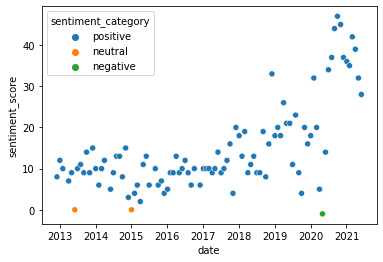

In [80]:
summary_sentiment_df = caluclate_sentiment_scores_afinn(summary_corpus)
summary_sentiment_df

There is only one negative sentiment score in the entire set. Perhaps the summaries are genereally positive regardess of the business environment.

In [81]:
# Find a sample of each extreme sentiment score
max_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].max()].index
min_sent_idx = summary_sentiment_df[summary_sentiment_df['sentiment_score'] == summary_sentiment_df['sentiment_score'].min()].index

# Show the most negative sentiment score sample, (first 500 chars)
print(f'Most Negative Summary:')
print(min_sent_idx.date)
pprint(summary_sentiment_df.loc[min_sent_idx,'corpus'].values[0][:500])

Most Negative Summary:
[datetime.date(2020, 5, 1)]
('Production , New Orders , Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Contracting ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Decreasing ; Exports '
 'Imports Contracting Economic activity manufacturing sector contracted April '
 ', overall economy contracted 131 consecutive months expansion , say nations '
 'supply executives latest Manufacturing ISM Report Business. " April PMI '
 'registered 41.5 percent , 7.6 percentage points March reading 49.')


In [82]:
# Show the most postive sentiment score sample, (first 500 chars)
print(f'Most Positive Summary:')
print(max_sent_idx.date)
pprint(summary_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

Most Positive Summary:
[datetime.date(2020, 10, 1)]
('New Orders Production Growing ; Employment Contracting ; Supplier Deliveries '
 'Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories '
 'Contracting ; Customers Inventories Low ; Prices Increasing ; Exports '
 'Imports Growing Economic activity manufacturing sector grew September , '
 'overall economy notching fifth consecutive month growth , say nations supply '
 'executives latest Manufacturing ISM Report Business. " September PMI '
 'registered 55.4 percent , 0.6 percentage point August reading 56 perc')


##### WRAS

,corpus,sentiment_score,sentiment_category
date,,,
2012-12-03,"Conditions still appear positive continued growth sales. "" Business steady , not much that. lull. "" principle business conditions affect company next three four quarters U.S. federal government ta...",-5.0,negative
2013-01-02,"Many Chinese sources coming us cost reductions maintain current business volumes. "" Saw stronger expected demand October November , December demand weak comparatively. "" seeing stabilization order...",8.0,positive
2013-02-01,"Fiscal cliff , uncertainty general EU economic weakness factors causing customers tentative commitments product purchases 2013. "" Midwest drought impact felt least midyear , impacting protein , sw...",6.0,positive
2013-04-01,"Beginning feel seasonal upswing business energy resin remain concern. "" Medical reimbursements insurance companies , particularly Medicare , slowing. "" second half 2013 looks promising , first hal...",11.0,positive
2013-05-01,"Business described flat best. "" Production still strong ; several new projects support alternative energy. "" Slight uptick business , overall continuing slowdown defense due budget/sequester. "" co...",11.0,positive
...,...,...,...
2021-02-01,"Supplier factory capacity well utilized. Increased demand , labor constraints upstream supply delays pushing lead times. prevalent international U.S.-based suppliers. "" Business remains strong. Ma...",12.0,positive
2021-03-01,coronavirus [ COVID-19 ] pandemic affecting us terms getting material build local overseas third- fourth-tier suppliers. Suppliers complaining [ lack ] available resources [ people ] manufacturing...,-13.0,negative
2021-04-01,"Late-winter storms unexpected [ areas ] U.S. organization exercising business-continuity plans much aggressive scale anticipated. storms slowed supply chain , could meet orders , even though short...",10.0,positive


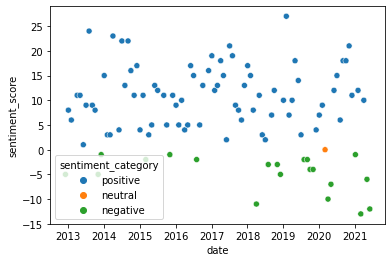

In [83]:
wras_sentiment_df = caluclate_sentiment_scores_afinn(wras_corpus)
wras_sentiment_df

There is a mixxture of positive and negative sentiment scores, and almost no neutral scores. Perhaps the compilers of the report like to pick  both negative and positive quotes to include in the report (likely manually--not programatically).

In [84]:
max_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].max()].index
min_sent_idx = wras_sentiment_df[wras_sentiment_df['sentiment_score'] == wras_sentiment_df['sentiment_score'].min()].index

print(min_sent_idx.date)
print(f'Most Negative WRAS:')
pprint(wras_sentiment_df.loc[min_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2021, 3, 1)]
Most Negative WRAS:
('coronavirus [ COVID-19 ] pandemic affecting us terms getting material build '
 'local overseas third- fourth-tier suppliers. Suppliers complaining [ lack ] '
 'available resources [ people ] manufacturing , creating major delivery '
 'issues. " Supply chains depleted ; inventories supply chain empty. Lead '
 'times increasing , prices increasing , [ ] demand increasing. Deep freeze '
 'Gulf Coast expected extend duration shortages. " Steel prices increased '
 'significantly recent months , driving costs suppliers propo')


In [85]:
# Show the most postive sentiment score sample, (first 500 chars)
print(max_sent_idx.date)
print(f'Most Positive WRAS:')
pprint(wras_sentiment_df.loc[max_sent_idx, 'corpus'].values[0][:500])

[datetime.date(2019, 2, 1)]
Most Positive WRAS:
('Unlike last years , experiencing first quarter slowdown. " Steady supply '
 'production environment. " Concerns oil prices fueling questions strong '
 'economy first half 2019. " Overall , business continues good ; however , '
 'margins squeezed. " federal government shutdown impacting ability get new '
 'products launched. wines need TTB [ Alcohol Tobacco Tax Trade Bureau ] '
 'approval. reforecasting accordingly. " continue enjoy benefits strong '
 'general economy. busy maintain backlog sales orders. " Incoming orde')


#### Using TextBlob lexicon

In [86]:
summary_corpus

['Economic activity manufacturing sector contracted November following two months modest expansion , overall economy grew 42nd consecutive month , say nations supply executives latest Manufacturing ISM Report Business. " PMI registered 49.5 percent , decrease 2.2 percentage points Octobers reading 51.7 percent , indicating contraction manufacturing fourth time last six months. months PMI reading reflects lowest level since July 2009 PMI registered 49.2 percent. New Orders Index registered 50.3 percent , decrease 3.9 percentage points October , indicating growth new orders third consecutive month. Production Index registered 53.7 percent , increase 1.3 percentage points , indicating growth production second consecutive month. Employment Index registered 48.4 percent , decrease 3.7 percentage points , indexs lowest reading since September 2009 Employment Index registered 47.8 percent. Prices Index registered 52.5 percent , reflecting decrease 2.5 percentage points. Comments panel month g

In [87]:
type(summary_corpus[1])


str

In [88]:
from textblob import TextBlob

def calculate_sentiment_scores_textblob(corpus, show_plot=True, return_df=True):
  sentiment_scores_tb = [round(TextBlob(release).sentiment.polarity, 3) for release in corpus]
  sentiment_category_tb = ['positive' if score > 0 
                              else 'negative' if score < 0 
                                  else 'neutral' 
                                      for score in sentiment_scores_tb]

  # Make dataframe
  sentiment_tb_df = pd.DataFrame([corpus, sentiment_scores_tb, sentiment_category_tb]).T
  sentiment_tb_df.columns = ['corpus', 'sentiment_score', 'sentiment_category']
  sentiment_tb_df['sentiment_score'] = sentiment_tb_df['sentiment_score'].astype('float')
  sentiment_tb_df['date'] = dates_ser[::-1].reset_index(drop=True)
  sentiment_tb_df = sentiment_tb_df.set_index('date')

  # Vizualize the dataframe
  if show_plot:
    sns.scatterplot(data=sentiment_tb_df,
                    x='date',
                    y='sentiment_score',
                    hue='sentiment_category',
                    hue_order=['positive', 'neutral', 'negative'])
  if return_df:
    return sentiment_tb_df

#### Summary

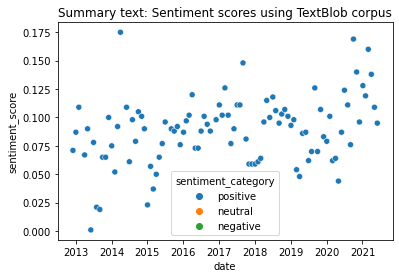

In [89]:
calculate_sentiment_scores_textblob(summary_corpus, return_df=False)
plt.title('Summary text: Sentiment scores using TextBlob corpus');

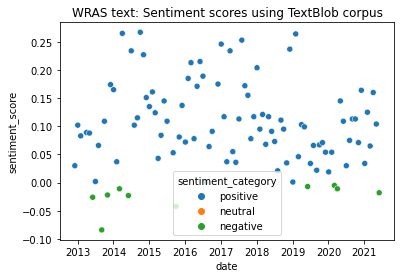

In [90]:
calculate_sentiment_scores_textblob(wras_corpus, return_df=False)
plt.title('WRAS text: Sentiment scores using TextBlob corpus');

# Feature Engineering & Text Representation

# Count-based Feature Engineering Models

Count-based are effective methods for extracting features from text. However, 
due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence, and context around nearby words in each text document.

## Advantages:
* Easy to understand, implement, and explain.
* Reproducible, and often deterministic
* Low computational cost
* Does not require much training data

## Disadvantages:
* Low performance


In [308]:
norm_summary_corpus_df = pd.DataFrame(norm_corpus_summary, columns=['document'])
norm_summary_corpus_df.head()

,document
0,economic activity manufacturing sector contract november follow two month modest expansion overall economy grow nd consecutive month say nation supply executive late manufacture ism report busines...
1,economic activity manufacturing sector expand december follow one month contraction overall economy grow rd consecutive month say nation supply executive late manufacture ism report business pmi r...
2,report reflect u department commerce recently complete annual adjustment seasonal factor use calculate index economic activity manufacturing sector expand january second consecutive month overall ...
3,economic activity manufacturing sector expand march fourth consecutive month overall economy grow th consecutive month say nation supply executive late manufacture ism report business pmi register...
4,economic activity manufacturing sector expand april fifth consecutive month overall economy grow th consecutive month say nation supply executive late manufacture ism report business pmi register ...


## Bag of Words Model

In [160]:
from sklearn.feature_extraction.text import CountVectorizer

# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus_summary)
cv_matrix

<99x710 sparse matrix of type '<class 'numpy.int64'>'
	with 11941 stored elements in Compressed Sparse Row format>

In [161]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix.toarray(), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,activity,add,addition,additionally,address,adequately,adjust,adjusted,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,...,trouble,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
94,1,0,1,0,0,0,0,0,2,0,0,0,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
95,0,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
96,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
97,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,6,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
98,0,0,1,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,14,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0


## Bag of N-Grams Model

In [257]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
# 2,2 to get bigrams only
# or 3,3, to get trigrams only
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus_summary)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab).tail()

,abate import,abate say,ability respond,absenteeism short,account overall,achieve year,across country,across entire,across industry,across many,action global,action input,actively evaluate,activity apparel,activity chemical,activity computer,activity continue,activity continued,activity contracting,activity dramatically,activity electrical,activity fabricate,activity food,activity furniture,activity historic,activity include,activity machinery,activity manufacturing,activity miscellaneous,activity nonmetallic,activity paper,activity petroleum,activity plastic,activity primary,activity september,activity textile,activity transportation,activity two,activity wood,add cost,...,well perform,well seventh,well sixth,well supplier,well support,well th,well third,west coast,whether government,whole learn,wide scale,winter high,wood product,work action,work june,work late,work survey,workaround add,worker absenteeism,worker cause,worker continue,worker remain,would consume,year among,year cap,year comment,year continue,year forward,year high,year increase,year indicate,year lead,year manufacturing,year new,year percentage,year positive,year say,year six,zero expansion,zero price
94,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## TF-IDF Model

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., 
                     max_df=0.99, # Discard words that appear in 99% of the documents
                     norm='l2',
                     use_idf=True, 
                     smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus_summary)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).tail()

,abate,ability,absenteeism,account,achieve,across,action,actively,add,addition,additionally,address,adequately,adjust,adjusted,adjustment,adverse,aerospace,affect,agreement,albeit,allied,along,also,although,aluminum,amid,among,annual,another,anticipate,apparel,appear,appliance,applicable,application,approach,approximately,april,area,...,trouble,turbulence,two,typical,unadjusted,uncertain,uncertainty,unchanged,undesired,unrest,upbeat,upon,upside,use,user,value,variable,view,volatility,volume,watch,watchful,weak,weaken,weakness,weather,weight,well,west,whether,whole,wide,winter,wood,work,workaround,worker,would,year,zero
94,0.06,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.23,0.0,0.04,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.05,0.00,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.06,0.0,...,0.00,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
95,0.00,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.06,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,...,0.00,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
96,0.00,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.0
97,0.00,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.07,0.0,0.00,0.06,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.18,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.00,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0
98,0.00,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.00,0.0,0.00,0.0,0.0,0.05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.06,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.42,0.0,...,0.07,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.05,0.0,0.0,0.0


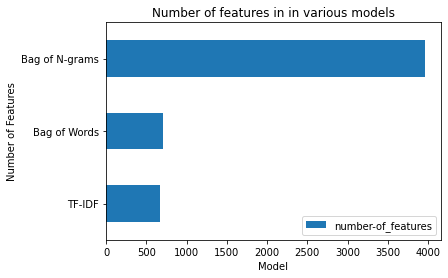

In [259]:
models_df = pd.Series([cv_matrix.shape[1], bv_matrix.shape[1], tv_matrix.shape[1]], 
                      index=['Bag of Words', 'Bag of N-grams', 'TF-IDF'], 
                      name='number-of_features').sort_values().to_frame()
models_df.plot(kind='barh')
plt.title('Number of features in in various models')
plt.ylabel('Number of Features')
plt.xlabel('Model');

We can see that there's about 5 times more features in the bag of n-grams model compared to the bag- of words model. TF-IDF has slightly fewer features than Bag of Words because we set teh TFIDF Vectorizer to drop words that occur in more than 99% of the documents.

## Document Similarity

Using the output of the TF-IDF Vectorizer, compare the similarity of the adjacent documents.

### Cosine Similarity

cosine_similarity is (1 - cosine_distance).

In [202]:
from sklearn.metrics.pairwise import pairwise_distances

cos_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='cosine')
cos_similarity_df = pd.DataFrame(cos_similarity_matrix)
cos_similarity_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
94,0.156945,0.246198,0.529678,0.134435,0.152198,0.139897,0.136603,0.111440,0.102863,0.100586,0.087961,0.107567,0.349680,0.567869,0.212824,0.110200,0.131682,0.142435,0.107137,0.118645,0.136287,0.114572,0.110052,0.299832,0.644742,0.268549,0.124506,0.138441,0.181043,0.143562,0.128904,0.100253,0.115083,0.092227,0.352974,0.607177,0.281561,0.116639,0.143992,0.145554,...,0.377738,0.309909,0.371807,0.377328,0.341473,0.345905,0.342951,0.321775,0.344676,0.343745,0.422263,0.625098,0.438621,0.328474,0.338474,0.385922,0.325704,0.319304,0.300173,0.267182,0.268538,0.272336,0.416597,0.707590,0.485642,0.316877,0.350583,0.404286,0.359664,0.417176,0.415796,0.407522,0.416998,0.480989,0.678074,1.000000,0.636038,0.459676,0.494476,0.514629
95,0.157320,0.147682,0.368411,0.257914,0.145650,0.131616,0.176616,0.117932,0.133966,0.124463,0.090399,0.116455,0.094459,0.315465,0.547409,0.291003,0.125714,0.147233,0.129830,0.128696,0.129311,0.139112,0.119800,0.096741,0.306714,0.536713,0.268980,0.131944,0.190201,0.137698,0.133173,0.105500,0.130684,0.104888,0.109479,0.275390,0.602602,0.269784,0.134124,0.158536,...,0.633656,0.419385,0.371452,0.386052,0.377208,0.358418,0.345828,0.293744,0.353959,0.346066,0.282312,0.446318,0.639589,0.429490,0.359391,0.402451,0.359381,0.333725,0.308090,0.292061,0.310100,0.313937,0.289151,0.420867,0.702545,0.394813,0.327710,0.386832,0.326904,0.402366,0.420157,0.421345,0.442944,0.476971,0.517426,0.636038,1.000000,0.610832,0.518502,0.539331
96,0.140326,0.116574,0.106814,0.504739,0.158519,0.142402,0.174218,0.129045,0.124665,0.149236,0.100191,0.131903,0.109479,0.091458,0.394458,0.452122,0.151333,0.131009,0.126342,0.176499,0.154447,0.153082,0.131858,0.115740,0.114745,0.327816,0.473817,0.261653,0.188267,0.132514,0.149439,0.113845,0.147622,0.100904,0.112872,0.121913,0.327918,0.544056,0.268808,0.134774,...,0.497460,0.629508,0.491037,0.395516,0.394608,0.381039,0.372298,0.339998,0.345825,0.342353,0.260427,0.317496,0.433436,0.583802,0.440944,0.332575,0.333043,0.308141,0.289786,0.279705,0.285795,0.285245,0.259584,0.269943,0.433145,0.561410,0.408460,0.361222,0.323180,0.397259,0.427307,0.409580,0.429958,0.450094,0.470544,0.459676,0.610832,1.000000,0.775666,0.632096
97,0.155269,0.116939,0.102812,0.409641,0.273885,0.197690,0.170019,0.123216,0.119727,0.125917,0.092045,0.127445,0.104549,0.102358,0.119795,0.334736,0.209156,0.146308,0.123957,0.212472,0.166538,0.144464,0.138927,0.123276,0.126968,0.127814,0.285619,0.519886,0.258242,0.128273,0.162749,0.122264,0.145275,0.108420,0.113008,0.103360,0.127412,0.372303,0.517879,0.219383,...,0.279083,0.506663,0.671861,0.467484,0.397540,0.405984,0.381000,0.354369,0.374747,0.355897,0.305840,0.336384,0.340898,0.410850,0.581526,0.419113,0.340169,0.351646,0.326653,0.303970,0.290336,0.291156,0.276503,0.261530,0.318215,0.439953,0.561915,0.433308,0.350500,0.415331,0.439255,0.423216,0.431537,0.467628,0.494671,0.494476,0.518502,0.775666,1.000000,0.736607
98,0.141595,0.118004,0.112004,0.144332,0.282444,0.331277,0.253287,0.133411,0.135541,0.136495,0.095137,0.166996,0.133125,0.090606,0.118047,0.145437,0.390907,0.301349,0.130099,0.211111,0.170954,0.164100,0.135785,0.111539,0.120571,0.113824,0.119276,0.290341,0.451166,0.241683,0.141393,0.111068,0.147764,0.101698,0.108402,0.103895,0.124642,0.136790,0.311714,0.483711,...,0.301797,0.411141,0.565793,0.676951,0.530092,0.428724,0.417231,0.378003,0.421858,0.365058,0.302273,0.358758,0.345097,0.322574,0.419147,0.562904,0.431439,0.352462,0.318528,0.289981,0.299762,0.302924,0.292427,0.276173,0.324011,0.294338,0.410910,0.599368,0.438389,0.437391,0.443412,0.424545,0.458599,0.480685,0.507262,0.514629,0.539331,0.632096,0.736607,1.000000


### [Jaccard Similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)

Jaccard_similarity is (1 - Jaccard_distance).

In [203]:
from sklearn.metrics import pairwise_distances

jac_similarity_matrix = 1 - pairwise_distances(tv_matrix, metric='jaccard')
jac_similarity_df = pd.DataFrame(jac_similarity_matrix)
jac_similarity_df.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
94,0.246231,0.240196,0.296703,0.237838,0.262032,0.230366,0.241935,0.236559,0.213904,0.216931,0.225641,0.219251,0.198953,0.293194,0.241935,0.225131,0.227027,0.262570,0.236559,0.243523,0.259459,0.227027,0.239362,0.216495,0.317204,0.234043,0.246231,0.241758,0.264249,0.219388,0.240642,0.232432,0.239362,0.204301,0.237569,0.313514,0.233696,0.229508,0.202247,0.245810,...,0.328042,0.349282,0.351759,0.343284,0.312500,0.326829,0.337900,0.325792,0.365000,0.375610,0.353535,0.363184,0.335000,0.342995,0.343137,0.347826,0.331731,0.358491,0.353211,0.362319,0.344340,0.345794,0.367713,0.423077,0.398010,0.384615,0.420561,0.426009,0.426009,0.480583,0.497872,0.509174,0.545455,0.684466,0.781250,1.000000,0.704663,0.557604,0.551570,0.528889
95,0.265193,0.264865,0.232955,0.257485,0.269006,0.248555,0.269461,0.248521,0.238095,0.248521,0.229050,0.222222,0.200000,0.232432,0.261905,0.272189,0.245509,0.285714,0.263473,0.270115,0.266272,0.260606,0.266272,0.232955,0.248619,0.252941,0.279330,0.262195,0.293103,0.229050,0.260355,0.259036,0.258824,0.234940,0.250000,0.258427,0.268293,0.263804,0.218750,0.283019,...,0.372781,0.384211,0.381215,0.371585,0.351064,0.352941,0.363184,0.343137,0.411111,0.391534,0.360656,0.328125,0.355191,0.348958,0.385870,0.375661,0.379679,0.386598,0.366337,0.384211,0.407407,0.408377,0.395122,0.378109,0.416216,0.379808,0.397059,0.417062,0.390698,0.459184,0.473451,0.519608,0.567010,0.631841,0.691099,0.704663,1.000000,0.644330,0.610837,0.616915
96,0.233161,0.221106,0.215054,0.273256,0.255556,0.236264,0.241573,0.242938,0.219101,0.250000,0.224599,0.217877,0.196721,0.227979,0.248588,0.251397,0.247126,0.263158,0.242938,0.270718,0.267045,0.254335,0.267045,0.241758,0.236842,0.261364,0.265957,0.241379,0.285714,0.224599,0.261364,0.252874,0.252809,0.222857,0.236994,0.252688,0.247126,0.250000,0.207101,0.260355,...,0.353933,0.409326,0.392473,0.375661,0.362694,0.371728,0.373786,0.373786,0.369792,0.366834,0.323077,0.320000,0.338542,0.333333,0.353846,0.345000,0.341709,0.356098,0.357143,0.380711,0.375000,0.383085,0.365741,0.330233,0.382653,0.357798,0.373832,0.375000,0.381166,0.425121,0.443038,0.456621,0.497608,0.552995,0.566038,0.557604,0.644330,1.000000,0.856354,0.695431
97,0.230000,0.212560,0.212435,0.254144,0.264865,0.239362,0.251366,0.239130,0.216216,0.232432,0.221649,0.215054,0.194737,0.231156,0.237838,0.240642,0.236264,0.258427,0.245902,0.272727,0.262295,0.243094,0.255435,0.238095,0.239796,0.243243,0.261538,0.244444,0.267016,0.215385,0.250000,0.248619,0.248649,0.219780,0.240223,0.242268,0.250000,0.232044,0.204545,0.255682,...,0.324468,0.393035,0.376289,0.353535,0.341584,0.363636,0.366197,0.353488,0.355000,0.352657,0.330000,0.307692,0.325000,0.326923,0.339901,0.344660,0.341463,0.355450,0.356481,0.379310,0.367150,0.361905,0.371041,0.324324,0.374384,0.339207,0.366516,0.367965,0.385965,0.415888,0.422764,0.446903,0.472477,0.540179,0.545455,0.551570,0.610837,0.856354,1.000000,0.710000
98,0.201970,0.202899,0.195876,0.222826,0.227513,0.222222,0.240437,0.221622,0.225275,0.215054,0.198980,0.197861,0.171875,0.202970,0.213904,0.216931,0.218579,0.247191,0.221622,0.248677,0.237838,0.225275,0.231183,0.227513,0.235897,0.206349,0.220000,0.213115,0.243523,0.223958,0.225806,0.224044,0.224599,0.195652,0.208791,0.219388,0.211957,0.207650,0.193182,0.237288,...,0.320856,0.369458,0.358974,0.364103,0.365482,0.346734,0.356808,0.350467,0.358586,0.349515,0.333333,0.323529,0.328283,0.298578,0.323529,0.341463,0.331707,0.333333,0.334862,0.342995,0.350962,0.365385,0.355856,0.339450,0.385000,0.336283,0.376147,0.371179,0.371179,0.406542,0.408907,0.438053,0.490654,0.524444,0.550459,0.528889,0.616915,0.695431,0.710000,1.000000


In [204]:
# Check the correlation of the two methods of calculating simlilarity
jac_similarity_df.corrwith(cos_similarity_df).mean()

0.5428552591070894

## Clustering documents using similarity features

### Using Cosine Similarity

In [205]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_cos = linkage(cos_similarity_matrix, 'ward')
# pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()

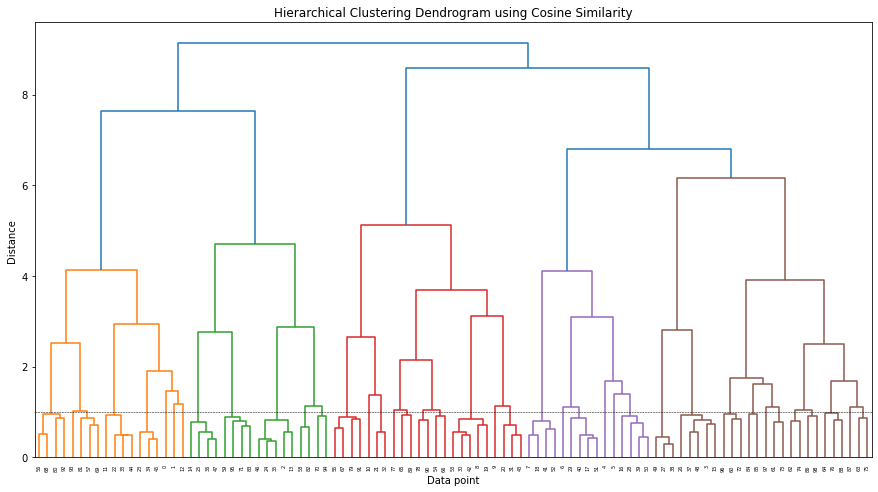

In [206]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Cosine Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_cos)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [207]:
from scipy.cluster.hierarchy import fcluster
max_dist = 0.5

cluster_labels_cos = fcluster(Z_cos, max_dist, criterion='distance')
cluster_labels_cos = pd.Series(cluster_labels_cos, name='cluster_label_using_cosine_similarity')
# cluster_labels_cos.value_counts()

### Using Jaccard Similarity

In [208]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z_jac = linkage(jac_similarity_matrix, 'ward')
# pd.DataFrame(Z_jac, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                          'Distance', 'Cluster Size'], dtype='object').tail()



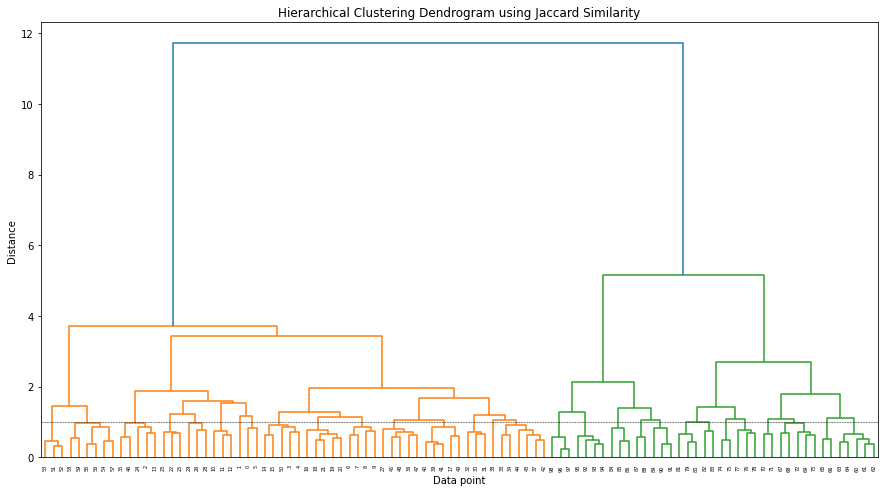

In [209]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram using Jaccard Similarity')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z_jac)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [210]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels_jac = fcluster(Z_jac, max_dist, criterion='distance')
cluster_labels_jac = pd.Series(cluster_labels_jac, name='cluster_label_using_jaccard_similarity')
# cluster_labels_jac.value_counts()

## Topic Models

In [239]:
n_components = 5
n_top_words = 20
max_iter = 1000

### Using [NMF](https://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf)

>The time complexity is polynomial in NMF.

In [263]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=n_components,
          beta_loss='kullback-leibler', 
          solver='mu', 
          max_iter=max_iter, 
          alpha=.1,
          l1_ratio=.5)
dt_matrix_nmf = nmf.fit_transform(tv_matrix)
features_nmf = pd.DataFrame(dt_matrix_nmf, columns=[f'Topic_{i}' for i in range(n_components)])
features_nmf.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
94,0.306049,3.469060e-01,9.521311e-16,1.010253e-26,2.747492e-14
95,0.333507,1.979325e-01,0.000000e+00,2.169198e-09,0.000000e+00
96,0.385454,8.060997e-12,0.000000e+00,1.231973e-01,0.000000e+00
97,0.446323,2.879654e-26,0.000000e+00,6.866267e-16,0.000000e+00
98,0.448543,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [269]:
# Show topics and their weights
tt_matrix_nmf = nmf.components_
for topic_weights in tt_matrix_nmf:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.5]
    print(topic)
    print()

[('inventory', 0.5398619956867695), ('april', 0.509889320846163)]

[('january', 1.1025484402798256), ('december', 0.6122175088155327)]

[('november', 0.8610433745625851), ('october', 0.8009433087367118)]

[('august', 0.9096363799494425), ('february', 0.594621015038191)]

[('june', 0.7909691266639731), ('may', 0.7056994113497638), ('july', 0.5092565255985042)]



### Using [LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

>In LDA, the time complexity is proportional to (n_samples * iterations).

In [242]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n_components, max_iter=max_iter)
dt_matrix_lda = lda.fit_transform(tv_matrix)
features_lda = pd.DataFrame(dt_matrix_lda, columns=[f'Topic_{i}' for i in range(n_components)])
features_lda

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,0.023973,0.023973,0.023973,0.023973,0.904108
1,0.023708,0.023708,0.023708,0.023708,0.905170
2,0.028019,0.028019,0.028019,0.028019,0.887923
3,0.031790,0.031790,0.031790,0.031790,0.872838
4,0.028395,0.028395,0.028395,0.028395,0.886420
...,...,...,...,...,...
94,0.018552,0.018552,0.018552,0.018552,0.925793
95,0.019420,0.019420,0.019420,0.019420,0.922320
96,0.018094,0.018094,0.018094,0.018094,0.927623
97,0.017486,0.017486,0.017486,0.017486,0.930057


In [274]:
# Show topics and their weights
tt_matrix_lda = lda.components_
for topic_weights in tt_matrix_lda:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.3]
    print(topic)
    print()

[]

[]

[]

[]

[('reading', 16.991734579684117), ('increase', 10.742903642045068), ('inventory', 9.054830064833933), ('decrease', 8.804642281286132), ('november', 8.496902139524336), ('august', 8.264052343434583), ('may', 8.033660153305682), ('april', 7.955271768256009), ('march', 7.918495906079817), ('february', 7.871920520966454), ('supplier', 7.8695739275300935), ('january', 7.816259362126075), ('price', 7.762563112460687), ('september', 7.7501604804140065), ('december', 7.709623828625427), ('continue', 7.676623898615212), ('october', 7.6319042380789295), ('june', 7.60983774738845), ('july', 7.411411555594659), ('delivery', 6.67179687327921), ('grow', 6.49980814764093), ('production', 6.245606694160511), ('employment', 6.018993588647314), ('expand', 5.963565239100498), ('compare', 5.876687031892735), ('th', 5.833730340789071), ('indicate', 5.234380139480701), ('low', 5.20670021700635), ('import', 5.159483517266146), ('contract', 5.086826710608018), ('material', 4.986162725409669), 

In [278]:
# Check the correlations of NMF and LDA topic models
pd.DataFrame(tt_matrix_nmf).corrwith(pd.DataFrame(tt_matrix_lda)).mean()

-0.10343223690570227

The correlation shows that the NMF and LDA produce mostly uncorrelated output.

### Clustering documents using topic model features

Let's compares the labels assigned by a Kmeans model of the topics for NMF and LDA

In [249]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_nmf)
cluster_labels_nmf = km.labels_
cluster_labels_nmf = pd.Series(cluster_labels, name='topic_labels_NMF', index=dates_ser)

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features_lda)
cluster_labels_lda = km.labels_
cluster_labels_lda = pd.Series(cluster_labels, name='topic_labels_LDA', index=dates_ser)

# summary_df.join((cluster_labels_nmf, cluster_labels_lda))[['topic_labels_NMF','topic_labels_LDA', 'summary']]

# Check the correlation of NMF vs LDA
cluster_labels_lda.corr(cluster_labels_nmf)

1.0

# Advanced (context-based) Feature Engineering Models

Traditional models have some limitations considering sparse representations,
leading to feature explosion and the curse of dimensionality. This is in addition to the already mentioned loss of context, ordering, and sequence of related words in text data.

Advanced feature engineering models, which use deep learning and neural network models generate dense embeddings for every word in any corpus, while retaining the context, ordering, and sequence of related words.

## Advantages:
* High performance
* High computational cost
* Requires large mounts of training data

## Disadvantages:
* Difficult to understand, implement, and explain.
* Not deterministic (uses random parameters upon initialization)

## Word2Vec

Let's use the GenSim implementation of Word2Vec.

In [289]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['grow', 'contract', 'month', 'slow', 'fast', 'delivery', 'customer', 'furniture', 'electronic']}

print("similar words based on gensim's model, where key is the word")
print('and the values are the top 5 words appearing in the context of the key word')
similar_words



similar words based on gensim's model, where key is the word
and the values are the top 5 words appearing in the context of the key word


{'contract': ['rate', 'contracting', 'fast', 'poor', 'backlog'],
 'customer': ['backlog', 'fast', 'low', 'growing', 'export'],
 'delivery': ['supplier', 'import', 'tighten', 'inventory', 'combine'],
 'electronic': ['chemical', 'coal', 'petroleum', 'transportation', 'computer'],
 'fast': ['rate', 'contracting', 'growing', 'slow', 'customer'],
 'furniture': ['paper', 'related', 'printing', 'wood', 'nonmetallic'],
 'grow': ['st', 'contracting', 'economic', 'nation', 'rate'],
 'month': ['fifth', 'fourth', 'read', 'third', 'consecutive'],
 'slow': ['contracting', 'growing', 'rate', 'fast', 'unchanged']}

The sample output here makes sense.

### Applying the word2vec model

In [299]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus_summary]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

# Check a sample word embedding
w2v_model.wv['delivery']

array([ 3.8119485 ,  0.27357465,  0.27424738, -4.7250967 , -6.4459844 ,
       -4.6384006 ,  4.9557137 ,  0.4720114 , -0.64682657,  5.0922027 ],
      dtype=float32)

### Build framework for getting document level embeddings

In [295]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [296]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,-2.045168,-0.117154,0.467456,0.127673,-1.482860,1.320708,2.440574,0.848951,-0.359193,0.970716
1,-2.169900,0.138491,0.512810,0.326723,-1.258850,1.285929,1.609286,0.679549,-0.558927,0.627891
2,-2.304335,-0.522214,-0.392022,0.277921,-1.949101,2.406146,2.018374,0.561748,-0.164265,0.278000
3,-2.019640,-0.936027,-0.004227,0.457757,-2.138857,2.034981,2.420212,1.167759,-0.377132,0.441962
4,-2.380992,-0.602099,0.184041,0.249557,-1.816434,1.754111,2.533802,1.103809,-0.390956,0.804421
...,...,...,...,...,...,...,...,...,...,...
94,-0.708157,0.170800,0.490077,-1.092514,-1.802593,-0.116886,2.057280,-0.033280,-0.266797,1.220564
95,-0.644094,-0.048774,0.721723,-0.847700,-1.872482,0.041224,2.058386,0.083483,-0.429496,1.131801
96,-0.245351,-0.148085,0.744219,-0.640866,-1.616981,-0.081466,2.040975,-0.001058,-0.537841,1.152098
97,-0.267067,-0.076019,0.761416,-0.679880,-1.665242,-0.246187,1.890103,0.056338,-0.516410,1.047382


### Clustering with word embeddings

In [305]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.Series(cluster_labels, name='w2v_cluster_label')
pd.concat([summary_corpus_df, cluster_labels], axis=1).tail()

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


,Document,w2v_cluster_label
94,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",6
95,"New Orders , Production &amp; Employment Growing Supplier Deliveries Slowing Faster Rate ; Backlog Growing Raw Materials Inventories Contracting ; Customers Inventories Low Prices Increasing ; Exp...",6
96,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",6
97,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Slower Rate ; Backlog Growing ; Raw Materials Inventories Contracting ; Customers Inventories Low ; Prices Increasing...",6
98,"New Orders , Production &amp; Employment Growing ; Supplier Deliveries Slowing Faster Rate ; Backlog Growing ; Raw Materials Inventories Growing ; Customers Inventories Low ; Prices Increasing ; E...",6


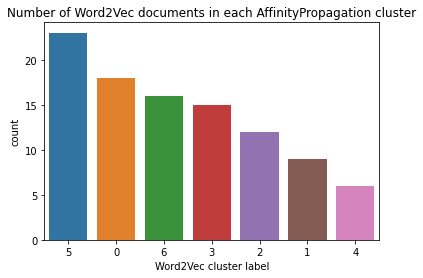

In [322]:
g = sns.countplot(x=cluster_labels, order=cluster_labels.value_counts().index)
g.set(title='Number of Word2Vec documents in each AffinityPropagation cluster',
      xlabel='Word2Vec cluster label');

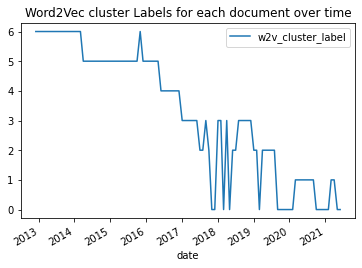

In [338]:
pd.DataFrame(cluster_labels).set_index(dates_ser).plot()
plt.title('Word2Vec cluster Labels for each document over time');

The cluster labels tends to stay the same for consecutive months (high autocorrelation). This makes sense, as the words in the documents should be similar for similar dates as the topics written in the monthly news releases are not expected to be very different each month.

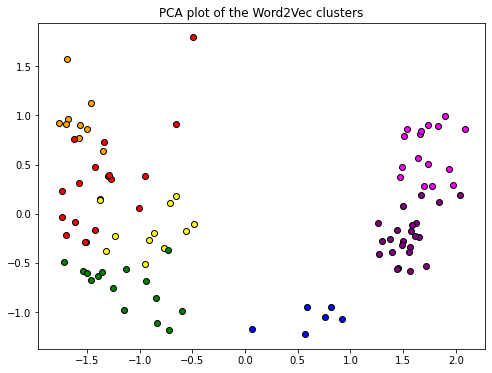

In [326]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
# categories = list(summary_corpus_df['Category'])
plt.figure(figsize=(8, 6))
plt.title('PCA plot of the Word2Vec clusters')
colors_dict = {0: 'red', 1: 'orange', 2:'yellow', 3:'green', 4:'blue', 5:'purple', 6:'magenta'}

for i in range(len(labels)):
    label = labels[i]
    # color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    color = colors_dict[label]
    # annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    # plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

## GloVe (Global Vectors)

Let's use the Spacy implementation of GloVe.

## Visualize GloVe word embeddings


In [382]:
nlp = spacy.load('en_core_web_sm')
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus_summary] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
deliver,0.345474,0.177434,0.124298,-0.409283,-0.284621,1.607978,-0.255422,-1.645028,0.322387,0.049454,-0.636286,0.401431,0.329945,-0.665413,-0.492421,0.374397,-0.334255,-0.099127,-1.007240,-0.448627,-0.052473,0.022420,0.110056,0.186014,-0.240138,0.213861,0.758443,0.028013,-0.193604,-0.239446,-0.835208,-1.212418,-0.557945,-0.852013,-0.063212,-0.133420,1.113969,1.165233,0.892047,1.032615,...,-0.784763,-0.342933,-0.043443,0.609411,-0.157762,1.266450,-0.443300,0.024992,-0.019694,0.662312,0.331655,0.234005,-0.569341,0.491040,0.815789,-0.053306,0.741672,-0.568095,-1.606025,0.960702,-0.625388,1.410114,0.001292,-1.511368,-0.711349,-0.143490,1.171245,-0.074187,-0.645209,0.477953,-0.112011,-0.427408,-0.665667,-1.120256,-0.624691,-0.855052,-0.503929,-0.139435,-0.076033,-1.237559
pmis,0.701454,0.470723,0.130434,-0.948301,-0.221546,-0.429540,-0.697182,-2.161697,-0.735730,-0.518441,-0.142567,0.475455,0.435283,1.067489,-0.925890,1.628807,0.967314,-0.248819,0.389666,0.425447,0.887096,0.273257,1.055461,0.459964,-0.464669,-0.285846,1.858216,-0.396773,-0.307510,-0.364395,0.003395,-0.534269,0.026934,-1.149008,0.996980,0.893108,-0.833907,1.236289,-0.215773,0.460530,...,0.170230,-0.418839,1.348829,0.032240,-0.062104,-0.592404,-0.349233,-1.117110,-0.268133,-0.052148,-0.421151,-0.449640,-0.096979,0.313387,0.363630,-1.079426,0.648698,-0.764493,-0.639743,0.501320,-0.497049,1.040809,-0.416873,0.526896,0.700403,-0.517773,0.545171,-0.113100,-0.654133,0.119781,-0.364060,-0.207621,-0.548405,0.297571,-0.105852,0.804804,0.053475,-0.484403,-1.109408,-0.482930
high,-0.657013,0.500744,-0.167493,-0.013354,-0.044743,0.346230,-0.127007,-0.717646,-0.373952,0.020730,-0.564289,-0.348744,-0.670913,-0.621195,-0.655421,2.498787,-0.665799,-1.060369,-0.670215,0.154490,1.486131,-0.203742,0.214656,0.636680,-0.013466,0.135531,-0.324072,-1.124263,0.161493,1.471456,-0.181509,0.422813,-1.173563,-1.143475,-0.236047,0.748675,-0.758954,0.180160,0.438121,0.935982,...,0.433998,0.529377,-0.070169,-0.968114,-0.528883,-0.060476,-0.785494,0.991645,0.778881,-0.708365,0.449053,-0.613455,0.721448,-0.203915,0.053974,0.082545,-0.306262,-0.730486,1.405024,0.779307,-0.564851,0.672890,0.736923,0.016966,-1.177893,-0.390015,0.303629,-0.424124,-0.061263,0.407032,-0.948547,-1.072665,-0.673430,-1.172790,-0.540214,0.659430,0.976007,-0.770570,0.686983,-0.850239
october,0.973439,1.468566,-0.299610,-1.022315,-1.093393,-0.553044,0.086122,-0.147436,-1.251645,-0.519203,0.013469,0.949190,0.181122,0.769502,-1.217463,0.751487,0.853850,-0.212640,-0.020376,-0.339773,-0.396239,0.571708,-0.223907,-0.119529,0.295083,0.938120,0.466934,-0.153493,-0.215622,-0.376173,-0.908890,-1.837323,-0.835522,-0.953210,2.723117,0.003443,-0.107785,-0.246502,-0.495744,0.110779,...,0.040035,-0.780395,0.487135,-0.161942,0.027190,1.329209,-0.049758,0.089644,0.218956,-0.248974,-0.191685,0.415013,0.940077,0.222945,0.582968,0.793171,0.602968,-0.632300,0.754101,0.106824,-0.268650,-0.576429,0.101637,0.877257,0.776438,-1.451602,-0.492267,0.175588,-1.109247,-1.113520,-0.049993,-0.069754,-0.773182,0.055017,-0.196032,2.106478,-0.191350,-0.400717,0.202613,-0.104391
extend,-0.831535,-0.811023,0.863540,-0.526680,0.264209,0.645848,0.378679,-1.108451,-0.587729,0.420616,-0.675911,-0.138283,0.082891,0.279853,-0.777840,0.667876,0.502607,-1.157407,0.130967,-0.004680,0.173383,0.356584,0.618740,0.084313,-0.550784,0.799355,0.239515,0.315633,-0.688977,0.894636,-1.388451,-1.071571,-0.388303,-0.514659,-0.456736,0.213552,0.726492,0.587218,0.502578,1.151319,...,-0.538117,-0.065587,0.754245,0.252587,-0.470872,-0.000243,-0.176483,0.958327,0.840243,1.004107,-0.863851,-0.429050,-0.315000,0.317252,1.044198,-0.962786,0.471172,-0.959969,-0.915878,0.934709,-0.935143,1.062463,-0.669919,-0.754330,-0.919057,0.124348,0.923368,0.628858,-0.45755

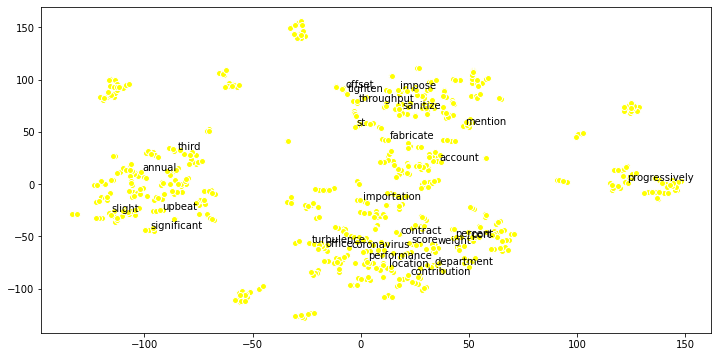

In [381]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='yellow', edgecolors='white')
skip_counter = 0
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  if skip_counter == 24:
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    skip_counter=0
  else:
    skip_counter += 1

There's no obvious pattern from the text annotations in the TSNE plot, but we can see  various small clusters and some  large clusters.

## FastText

# Supervised Learning Models for Text Data


# Unsupervised Learning Models for Text Data

# Advanced Topics